In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from scipy import stats
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel,ttest_ind,wilcoxon
import json
import statsmodels.api as sm
import pylab as py

from tqdm import trange

import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis')
# import final_analysis.plot_helper.format

In [2]:
save_mode = ".pdf"
font_size = 18

In [4]:
# import rpy2
# import rpy2.situation as r_situation
# print(r_situation.get_r_home())

# !python -m rpy2.situation
# %load_ext rpy2.ipython

%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

/Users/dbao/opt/anaconda3/envs/road/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [5]:
# home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
# home_dir = '../../../2022_online/'
home_dir = '/Users/dbao/Library/CloudStorage/GoogleDrive-sherrydbao@gmail.com/.shortcut-targets-by-id/1sYZNVBbYCrHcHjo-9xdKcA4wLnob9ZEq/'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
# out_dir = home_dir + 'figures/cogsci_2022/'
out_dir = home_dir + 'figures/figures_final/'
R_out_dir = home_dir + 'R_analysis_data/'

In [6]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index()

In [7]:
# load map
# with open(home_dir + map_dir + 'tree/map_tree_trueopt', 'r') as file:
#     map_tree = json.load(file)
with open(home_dir + map_dir + '/basicMap.json', 'r') as file:
    map = json.load(file)

# *Figure 1 (demo)

## a. actual map of do and undo

In [6]:
# check which sub and map has only one single undo 
subs = []
maps = []
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

for sub in range(100):
    dat_sbj_undo = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    for pzi in np.unique(dat_sbj_undo['puzzleID']):
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        if dat_sbj_undo_pzi['firstUndo'].sum() == 1:
            subs.append(sub)
            maps.append(pzi)
for i in range(len(subs)):
    print(f"Subject: {subs[i]}, Map: {maps[i]}")

Subject: 0, Map: 0
Subject: 0, Map: 2
Subject: 0, Map: 14
Subject: 0, Map: 18
Subject: 0, Map: 23
Subject: 0, Map: 28
Subject: 1, Map: 2
Subject: 1, Map: 3
Subject: 1, Map: 7
Subject: 1, Map: 9
Subject: 1, Map: 10
Subject: 1, Map: 12
Subject: 1, Map: 13
Subject: 1, Map: 14
Subject: 1, Map: 15
Subject: 1, Map: 16
Subject: 1, Map: 20
Subject: 1, Map: 25
Subject: 1, Map: 30
Subject: 1, Map: 33
Subject: 1, Map: 34
Subject: 1, Map: 36
Subject: 1, Map: 37
Subject: 1, Map: 38
Subject: 1, Map: 42
Subject: 1, Map: 44
Subject: 1, Map: 45
Subject: 2, Map: 2
Subject: 2, Map: 3
Subject: 2, Map: 8
Subject: 2, Map: 11
Subject: 2, Map: 12
Subject: 2, Map: 17
Subject: 2, Map: 25
Subject: 2, Map: 32
Subject: 2, Map: 34
Subject: 2, Map: 35
Subject: 3, Map: 6
Subject: 3, Map: 12
Subject: 3, Map: 26
Subject: 3, Map: 28
Subject: 3, Map: 32
Subject: 3, Map: 41
Subject: 4, Map: 6
Subject: 4, Map: 8
Subject: 4, Map: 9
Subject: 4, Map: 11
Subject: 4, Map: 12
Subject: 4, Map: 14
Subject: 4, Map: 15
Subject: 4, M

In [7]:
def find_sublist_index(target, list_of_sublists):
    try:
        return list_of_sublists.index(target)
    except ValueError:
        return -1  # returns -1 if the sublist is not found

In [8]:
# sub = 1
# sub = 4
sub = 0
pzi = 0
# pzi = 9

# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
# dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])
TS = map[pzi]

dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()

print(dat_sbj_undo_pzi['path'])

# get distance from TS['xy'][0] to TS['xy'][1:]
start = np.array(TS['xy'][0])
distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]

TS = map[pzi]

R = 300.0

rem_xy = TS['xy'].copy()
# pop the current one
curr_xy = rem_xy.pop(0)
cts_in_order = []
cts_in_order.append(curr_xy)
cts_idx_in_order = [find_sublist_index(curr_xy, TS['xy'])]

paths = [] 
# index of first undo == 1 to numbers
fundo_indexes = dat_sbj_undo_pzi.index[dat_sbj_undo_pzi['firstUndo'] == 1].tolist()
lundo_indexes = dat_sbj_undo_pzi.index[dat_sbj_undo_pzi['lastUndo'] == 1].tolist()
dosrt_indexes = np.array([-1, *lundo_indexes])
dosrt_indexes = dosrt_indexes + 1
doend_indexes = np.array([*fundo_indexes, len(dat_sbj_undo_pzi)])


for i in range(len(dat_sbj_undo_pzi)-1):
    paths.append([TS['xy'][dat_sbj_undo_pzi['choice'][i]], TS['xy'][dat_sbj_undo_pzi['choice'][i+1]]])
print(paths)

first_do_connected = []
for i in range(dosrt_indexes[0], doend_indexes[0]):
    first_do_connected.append(dat_sbj_undo_pzi['choice'].iloc[i])
print(first_do_connected)
# first do sequence
print(dat_sbj_undo_pzi['path'].iloc[dosrt_indexes[0]:doend_indexes[0]])

first_undo_connected = []
for i in range(fundo_indexes[0]-1, lundo_indexes[0]+1):
    first_undo_connected.append(dat_sbj_undo_pzi['choice'].iloc[i])
print(first_undo_connected)
# if last of first undo is not 0, then append to first_undo_alrdy

# first undo sequence
print(dat_sbj_undo_pzi['path'].iloc[fundo_indexes[0]-1:lundo_indexes[0]+1])


0                                [0]
1                            [0, 20]
2                        [0, 20, 28]
3                     [0, 20, 28, 5]
4                  [0, 20, 28, 5, 4]
5              [0, 20, 28, 5, 4, 24]
6          [0, 20, 28, 5, 4, 24, 26]
7      [0, 20, 28, 5, 4, 24, 26, 12]
8          [0, 20, 28, 5, 4, 24, 26]
9              [0, 20, 28, 5, 4, 24]
10                 [0, 20, 28, 5, 4]
11                    [0, 20, 28, 5]
12                       [0, 20, 28]
13                           [0, 20]
14                        [0, 20, 5]
15                     [0, 20, 5, 4]
16                 [0, 20, 5, 4, 24]
17             [0, 20, 5, 4, 24, 15]
18          [0, 20, 5, 4, 24, 15, 7]
19       [0, 20, 5, 4, 24, 15, 7, 8]
20    [0, 20, 5, 4, 24, 15, 7, 8, 3]
21    [0, 20, 5, 4, 24, 15, 7, 8, 3]
Name: path, dtype: object
[[[24, 135], [-41, 81]], [[-41, 81], [-5, 34]], [[-5, 34], [-46, 19]], [[-46, 19], [-44, -6]], [[-44, -6], [-53, -13]], [[-53, -13], [-36, -15]], [[-36, -15], [

In [9]:
print(first_do_connected)
path_do_connected = []
for i in range(len(first_do_connected)-1):
    path_do_connected.append([TS['xy'][first_do_connected[i]], TS['xy'][first_do_connected[i+1]]])
print(path_do_connected)

[0, 20, 28, 5, 4, 24, 26, 12]
[[[24, 135], [-41, 81]], [[-41, 81], [-5, 34]], [[-5, 34], [-46, 19]], [[-46, 19], [-44, -6]], [[-44, -6], [-53, -13]], [[-53, -13], [-36, -15]], [[-36, -15], [-1, -19]]]


In [10]:
fig1a_data = {}

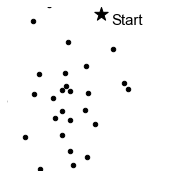

In [11]:
# figure that shows how do improves for greedy policy by gradients of red colors that shows how they improved from start to the end
%matplotlib inline
fig, ax = plt.subplots(figsize=(3,3))

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 15

# plo the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)
ax.annotate('Start', (TS['xy'][0][0]+20, TS['xy'][0][1]-20), fontsize=15, c='k')
    
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=200, marker='*', alpha=1)

# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

    
# x lim y lim
ax.set_xlim([-160, 160])
ax.set_ylim([-170, 150])

# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

# make axis equal
ax.set_aspect('equal') 

fig1a_data['0'] = {'x': TS['xy'][0][0], 'y': TS['xy'][0][1]}

plt.savefig(out_dir + 'do_0' + save_mode, bbox_inches='tight', pad_inches=0.1)

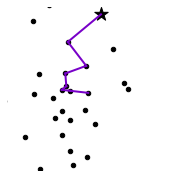

In [12]:
# figure that shows how do improves for greedy policy by gradients of red colors that shows how they improved from start to the end
%matplotlib inline
fig, ax = plt.subplots(figsize=(3,3))

# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['font.size'] = 15


# green_values = [200, 160, 120, 80, 40]
# green_values = [100, 125, 150, 175, 200]
green_values = np.linspace(200, 200, len(path_do_connected)).astype(int)
colors = [f'#{0:02x}{v:02x}{0:02x}' for v in green_values]

purple_values = np.linspace(200, 200, len(path_do_connected)).astype(int)
colors = [(v / 255.0 * 0.6, 0.0, v / 255.0) for v in purple_values]  # Purple tones

ax.set_aspect('equal') 
# plot the optimal path
for i in range(len(path_do_connected)):
    ax.plot([path_do_connected[i][0][0], path_do_connected[i][1][0]], [path_do_connected[i][0][1], path_do_connected[i][1][1]], color=colors[i], linewidth=2, alpha=1)


# plot the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)
# ax.annotate('Start', (TS['xy'][0][0]+20, TS['xy'][0][1]-15), fontsize=18, c='r')
    
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=200, marker='*', alpha=1)

# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

    
# x lim y lim
ax.set_xlim([-160, 160])
ax.set_ylim([-170, 150])

# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

fig1a_data['1'] = {'x': TS['xy'][0][0], 'y': TS['xy'][0][1], 'path_do_connected': deepcopy(path_do_connected), 'colors': deepcopy(colors)}

# make axis equal
plt.savefig(out_dir + 'do_1' + save_mode, bbox_inches='tight', pad_inches=0.1)

In [13]:
print(first_undo_connected)
path_undo_connected = []
for i in range(len(first_undo_connected)-1):
    path_undo_connected.append([TS['xy'][first_undo_connected[i]], TS['xy'][first_undo_connected[i+1]]])
print(path_undo_connected)

print(first_do_connected)
# difference between first_do_connected and first_undo_connected
first_do_remaining = [i for i in first_do_connected if i not in first_undo_connected]
first_do_remaining.append(first_undo_connected[-1])
print(first_do_remaining)
path_do_remaining = []
for i in range(len(first_do_remaining)-1):
    path_do_remaining.append([TS['xy'][first_do_remaining[i]], TS['xy'][first_do_remaining[i+1]]])

[12, 26, 24, 4, 5, 28, 20]
[[[-1, -19], [-36, -15]], [[-36, -15], [-53, -13]], [[-53, -13], [-44, -6]], [[-44, -6], [-46, 19]], [[-46, 19], [-5, 34]], [[-5, 34], [-41, 81]]]
[0, 20, 28, 5, 4, 24, 26, 12]
[0, 20]


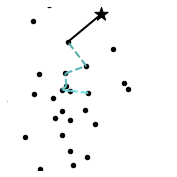

In [14]:
# figure that shows how do improves for greedy policy by gradients of red colors that shows how they improved from start to the end
%matplotlib inline
fig, ax = plt.subplots(figsize=(3,3))

# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['font.size'] = 15

# orange_values = np.linspace(250, 250, len(path_undo_connected)).astype(int)
# orange_values = orange_values[::-1]
# colors = [(v / 255.0, v / 255.0 * 0.5, 0.0) for v in orange_values]

mint_values = np.linspace(220, 170, len(path_undo_connected)).astype(int)
colors = [(v / 255.0 * 0.5, v / 255.0, v / 255.0 ) for v in mint_values]  # Softer mint tone


ax.set_aspect('equal') 
# plot the optimal path
for i in range(len(path_undo_connected)):
    ax.plot([path_undo_connected[i][0][0], path_undo_connected[i][1][0]],
            [path_undo_connected[i][0][1], path_undo_connected[i][1][1]], color=colors[i], linewidth=2, alpha=1, linestyle='--')
for i in range(len(path_do_remaining)):
    ax.plot([path_do_remaining[i][0][0], path_do_remaining[i][1][0]],
            [path_do_remaining[i][0][1], path_do_remaining[i][1][1]], color='k', linewidth=2, alpha=1)


# plot the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)
# ax.annotate('Start', (TS['xy'][0][0]+20, TS['xy'][0][1]-15), fontsize=18, c='r')
    
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=200, marker='*', alpha=1)

# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

    
# x lim y lim
ax.set_xlim([-160, 160])
ax.set_ylim([-170, 150])


# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

fig1a_data['2'] = {'x': TS['xy'][0][0], 'y': TS['xy'][0][1], 'path_undo_connected': deepcopy(path_undo_connected), 'path_do_remaining': deepcopy(path_do_remaining), 'colors': deepcopy(colors)}

# make axis equal
plt.savefig(out_dir + 'undo_1' + save_mode, bbox_inches='tight', pad_inches=0.1)

In [15]:
second_do_connected = [first_do_remaining[-1]]
for i in range(dosrt_indexes[1], doend_indexes[1]):
    second_do_connected.append(dat_sbj_undo_pzi['choice'].iloc[i])
second_do_connected = second_do_connected[:-1]
print(second_do_connected)

[20, 5, 4, 24, 15, 7, 8, 3]


In [16]:
print(second_do_connected)
path_do_connected = []
for i in range(len(second_do_connected)-1):
    path_do_connected.append([TS['xy'][second_do_connected[i]], TS['xy'][second_do_connected[i+1]]])
print(path_do_connected)

[20, 5, 4, 24, 15, 7, 8, 3]
[[[-41, 81], [-46, 19]], [[-46, 19], [-44, -6]], [[-44, -6], [-53, -13]], [[-53, -13], [-70, -29]], [[-70, -29], [-53, -55]], [[-53, -55], [-67, -68]], [[-67, -68], [-37, -73]]]


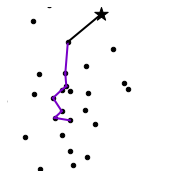

In [17]:
# figure that shows how do improves for greedy policy by gradients of red colors that shows how they improved from start to the end
%matplotlib inline
fig, ax = plt.subplots(figsize=(3,3))

# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['font.size'] = 15


# green_values = [200, 160, 120, 80, 40]
green_values = np.linspace(200, 200, len(path_do_connected)).tolist()
colors = [f'#{0:02x}{int(v):02x}{0:02x}' for v in green_values]

purple_values = np.linspace(200, 200, len(path_do_connected)).astype(int)
colors = [(v / 255.0 * 0.6, 0.0, v / 255.0) for v in purple_values]  # Purple tones



# # reverse order
# colors = colors[::-1]

# yellow_values = np.linspace(230, 220, len(path_do_connected)).astype(int)  # Light to darker yellow
# colors = [(v / 255.0, v / 255.0, 0.0) for v in yellow_values]  # RGB format

# colors = [(v / 255.0, v / 255.0 * 0.5, 0.0) for v in green_values]

ax.set_aspect('equal') 
# plot the optimal path
for i in range(len(path_do_connected)):
    ax.plot([path_do_connected[i][0][0], path_do_connected[i][1][0]], [path_do_connected[i][0][1], path_do_connected[i][1][1]], color=colors[i], linewidth=2, alpha=1)
for i in range(len(path_do_remaining)):
    ax.plot([path_do_remaining[i][0][0], path_do_remaining[i][1][0]], [path_do_remaining[i][0][1], path_do_remaining[i][1][1]], color='k', linewidth=2, alpha=1)

# plot the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)
# ax.annotate('Start', (TS['xy'][0][0]+20, TS['xy'][0][1]-15), fontsize=18, c='r')
    
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=200, marker='*', alpha=1)

# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

    
# x lim y lim
ax.set_xlim([-160, 160])
ax.set_ylim([-170, 150])

# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

fig1a_data['3'] = {'x': TS['xy'][0][0], 'y': TS['xy'][0][1], 'path_do_connected': deepcopy(path_do_connected), 'path_do_remaining': deepcopy(path_do_remaining), 'colors': deepcopy(colors)}

# make axis equal
plt.savefig(out_dir + 'do_2' + save_mode, bbox_inches='tight', pad_inches=0.1)

In [18]:
submit_do = [*first_do_remaining]
# append second_do_connected to submit_do
submit_do += second_do_connected[1:]
print(submit_do)

path_submit = []
for i in range(len(submit_do)-1):
    path_submit.append([TS['xy'][submit_do[i]], TS['xy'][submit_do[i+1]]])
    


[0, 20, 5, 4, 24, 15, 7, 8, 3]


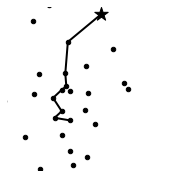

In [19]:
# figure that shows how do improves for greedy policy by gradients of red colors that shows how they improved from start to the end
%matplotlib inline
fig, ax = plt.subplots(figsize=(3,3))

# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['font.size'] = 15


# green_values = [200, 160, 120, 80, 40]
green_values = np.linspace(100, 200, len(path_do_connected)).tolist()
colors = [f'#{0:02x}{int(v):02x}{0:02x}' for v in green_values]
# colors = [(v / 255.0, v / 255.0 * 0.5, 0.0) for v in green_values]

ax.set_aspect('equal') 
# plot the optimal path
for i in range(len(path_submit)):
    ax.plot([path_submit[i][0][0], path_submit[i][1][0]], [path_submit[i][0][1], path_submit[i][1][1]], color='k', linewidth=2, alpha=1)

# plot the map
for i in range(len(TS['xy'])):
    ax.scatter(TS['xy'][i][0], TS['xy'][i][1], color='black', s=20)
# ax.annotate('Start', (TS['xy'][0][0]+20, TS['xy'][0][1]-15), fontsize=18, c='r')
    
ax.scatter(TS['xy'][0][0], TS['xy'][0][1], color='k', s=200, marker='*', alpha=1)

# grid off
ax.grid(False)

# remove all borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

    
# x lim y lim
ax.set_xlim([-160, 160])
ax.set_ylim([-170, 150])


# x ticks and y ticks
ax.set_xticks([])
ax.set_yticks([])

fig1a_data['4'] = {'x': TS['xy'][0][0], 'y': TS['xy'][0][1], 'path_submit': deepcopy(path_submit), 'colors': deepcopy(colors)}

# make axis equal
plt.savefig(out_dir + 'submit_2' + save_mode, bbox_inches='tight', pad_inches=0.1)

NameError: name 'fig1a_data' is not defined

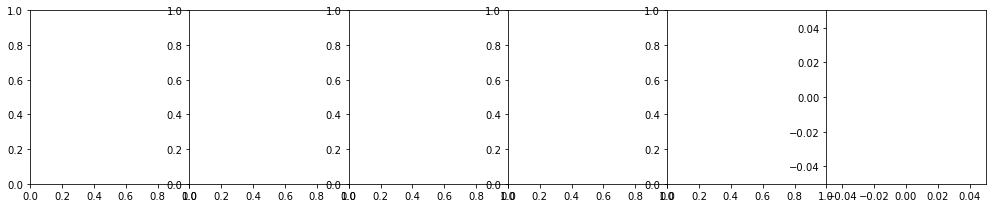

In [3]:
# combine the figures above to make a single figure
# load fig from fig1a_data and plot on the first subplot in 5 columns
%matplotlib inline
fig, ax = plt.subplots(figsize=(14,3), ncols=6)
# tight layout with no gap between the subplots AND no space around the figure
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(0)

# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['font.size'] = 15

# plot the map from fig1a_data
for i in range(5):
    x = fig1a_data[str(i)]['x']
    y = fig1a_data[str(i)]['y']
    
    for j in range(len(TS['xy'])):
        ax[i].scatter(TS['xy'][j][0], TS['xy'][j][1], color='black', s=20)
    ax[i].annotate('Start', (TS['xy'][0][0]+20, TS['xy'][0][1]-20), fontsize=18, c='k')
    
    # check if fig1a_data has colors as key
    if 'colors' in fig1a_data[str(i)].keys():
        colors = fig1a_data[str(i)]['colors']
    ax[i].scatter(x, y, color='k', s=200, marker='*', alpha=1)
    if i ==1:
        path_do_connected = fig1a_data[str(i)]['path_do_connected']
        for j in range(len(path_do_connected)):
            ax[i].plot([path_do_connected[j][0][0], path_do_connected[j][1][0]], [path_do_connected[j][0][1], path_do_connected[j][1][1]], color=colors[j], linewidth=2, alpha=1)
    elif i ==2:
        path_undo_connected = fig1a_data[str(i)]['path_undo_connected']
        for j in range(len(path_undo_connected)):
            ax[i].plot([path_undo_connected[j][0][0], path_undo_connected[j][1][0]], [path_undo_connected[j][0][1], path_undo_connected[j][1][1]], color=colors[j], linewidth=2, alpha=1, linestyle='--')
        path_do_remaining = fig1a_data[str(i)]['path_do_remaining']
        for j in range(len(path_do_remaining)):
            ax[i].plot([path_do_remaining[j][0][0], path_do_remaining[j][1][0]], [path_do_remaining[j][0][1], path_do_remaining[j][1][1]], color='k', linewidth=2, alpha=1)
    elif i ==3:
        path_do_connected = fig1a_data[str(i)]['path_do_connected']
        for j in range(len(path_do_connected)):
            ax[i].plot([path_do_connected[j][0][0], path_do_connected[j][1][0]], [path_do_connected[j][0][1], path_do_connected[j][1][1]], color=colors[j], linewidth=2, alpha=1)
        path_do_remaining = fig1a_data[str(i)]['path_do_remaining']
        for j in range(len(path_do_remaining)):
            ax[i].plot([path_do_remaining[j][0][0], path_do_remaining[j][1][0]], [path_do_remaining[j][0][1], path_do_remaining[j][1][1]], color='k', linewidth=2, alpha=1)
    elif i ==4:
        path_submit = fig1a_data[str(i)]['path_submit']
        for j in range(len(path_submit)):
            ax[i].plot([path_submit[j][0][0], path_submit[j][1][0]], [path_submit[j][0][1], path_submit[j][1][1]], color='k', linewidth=2, alpha=1)
    # grid off
    ax[i].grid(False)
    
    # remove all borders
    # for spine in ax[i].spines.values():
        # spine.set_visible(False)
        
    
        
    # x lim y lim
    ax[i].set_xlim([-160, 160])
    ax[i].set_ylim([-170, 150])
    
    # x ticks and y ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    # make axis equal
    ax[i].set_aspect('equal')
    
ax[5].set_position([0.89, 0.05, 0.2, 0.85])

plt.savefig(out_dir + 'do_submit' + save_mode, bbox_inches='tight', pad_inches=0.1)

# *Plot between conditions


In [8]:
import matplotlib
# matplotlib.rcdefaults()
import final_analysis.plot_helper.format

In [9]:
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

time_taken =[]
first_RT = []

firstMove_RTs_per_MAS = []
laterMove_RTs_per_MAS = []

submit_RT = []
# submit_RT_UNA = []

firstMove_RTs_per_MAS_UNA = []
laterMove_RTs_per_MAS_UNA = []


for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    time_taken_puzzle = []
    first_RT_puzzle = []

    submit_RT_puzzle = []
    # submit_RT_puzzle_UNA = []

    firstMove_RTs_per_MAS_puzzle = []
    laterMove_RTs_per_MAS_puzzle = []

    firstMove_RTs_per_MAS_puzzle_UNA = []
    laterMove_RTs_per_MAS_puzzle_UNA = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID']==pzi]
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID']==pzi]
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID']==pzi]

        time_taken_puzzle.append([np.sum(dat_sbj_undo_pzi['RT'][1:])+np.sum(dat_sbj_undo_pzi['undoRT']), np.sum(dat_sbj_basic_pzi['RT'][1:]) ])

        submit_RT_puzzle.append([dat_sbj_undo_pzi['RT'].iloc[-1], dat_sbj_basic_pzi['RT'].iloc[-1], dat_sbj_undo_pzi['currMas'].iloc[0]])

        first_RT_puzzle.append([(dat_sbj_undo_pzi['RT'].iloc[1]), (dat_sbj_basic_pzi['RT'].iloc[1])])

        # firstmove RTs
        firstMove_RTs_per_MAS_puzzle.append([np.array(dat_sbj_undo_pzi['RT'])[1], dat_sbj_undo_pzi['currMas'].iloc[0]])
        # index of move that is not undo
        idx_not_undo = np.where(dat_sbj_undo_pzi['undo']==0)[0]
        laterMove_RTs_per_MAS_puzzle.append([np.mean(np.array(dat_sbj_undo_pzi['RT'])[idx_not_undo[1:-1]]), dat_sbj_undo_pzi['currMas'].iloc[0]])

        # firstmove RTs in undo not allowed
        firstMove_RTs_per_MAS_puzzle_UNA.append([np.array(dat_sbj_basic_pzi['RT'])[1], dat_sbj_basic_pzi['currMas'].iloc[0]])
        # index of move that is not undo
        idx_not_undo = np.where(dat_sbj_basic_pzi['undo']==0)[0]
        laterMove_RTs_per_MAS_puzzle_UNA.append([np.mean(np.array(dat_sbj_basic_pzi['RT'])[idx_not_undo[1:-1]]), dat_sbj_basic_pzi['currMas'].iloc[0]])

    time_taken.append(time_taken_puzzle)
    first_RT.append(first_RT_puzzle)

    submit_RT.append(submit_RT_puzzle)

    firstMove_RTs_per_MAS.append(firstMove_RTs_per_MAS_puzzle)
    laterMove_RTs_per_MAS.append(laterMove_RTs_per_MAS_puzzle)

    firstMove_RTs_per_MAS_UNA.append(firstMove_RTs_per_MAS_puzzle_UNA)
    laterMove_RTs_per_MAS_UNA.append(laterMove_RTs_per_MAS_puzzle_UNA)

time_taken = np.array(time_taken)
first_RT = np.array(first_RT)
submit_RT = np.array(submit_RT)

firstMove_RTs_per_MAS = np.array(firstMove_RTs_per_MAS)
laterMove_RTs_per_MAS = np.array(laterMove_RTs_per_MAS)



firstMove_RTs_per_MAS_UNA = np.array(firstMove_RTs_per_MAS_UNA)
laterMove_RTs_per_MAS_UNA = np.array(laterMove_RTs_per_MAS_UNA)

In [10]:
# compariosn between performance
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

error_magnitude = []
error_magnitude_mean = []
error_magnitude_all = []
error_magnitude_firstMove_mean = []

error_magnitude_mean_didnotundo = []
error_magnitude_mean_didundo = []

cum_error_UA_UNA = []
first_error_UA_UNA = []

optimality_firstmove = []

greedy_action = []
error_action = []
leftover = []

num_undo_per_mas = []
total_RT_per_mas = []
total_RT_per_mas_undoallowed = []
cumul_error_mag_per_mas = []




for sub in range(100):

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    error_magnitude_puzzle = []
    error_magnitude_firstMove_puzzle = []

    error_magnitude_mean_didnotundo_puzzle = []
    error_magnitude_mean_didundo_puzzle = []

    optimality_firstmove_puzzle = []

    greedy_action_puzzle = []
    error_action_puzzle = []
    leftover_puzzle = []

    cum_error_UA_UNA_puzzle = []
    first_error_UA_UNA_puzzle = []

    num_undo_per_mas_puzzle = []
    total_RT_per_mas_puzzle = []

    total_RT_per_mas_undoallowed_puzzle = []

    cumul_error_mag_per_mas_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        error_magnitude_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                  np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])
        error_magnitude_firstMove_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                  np.array(dat_sbj_basic_pzi['currMas'])[1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])

        # check if dat_sbj_undo_pzi['undo'].sum() is 0 or not
        if dat_sbj_undo_pzi['undo'].sum() == 0:
            error_magnitude_mean_didnotundo_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                                           np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])
        else:
            error_magnitude_mean_didundo_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                                        np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])

        optimality_firstmove_puzzle.append([dat_sbj_undo_pzi['currMas'][1]-dat_sbj_undo_pzi['currMas'][0],
                                            dat_sbj_basic_pzi['currMas'][1]-dat_sbj_basic_pzi['currMas'][0]])

        # get distance from TS['xy'][0] to TS['xy'][1:]
        start = np.array(TS['xy'][0])
        # distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]
        distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy']]

        # find the index that is second shortest distance because the first shortest is goint back to itself
        idx = np.argsort(distance)[1]

        # get proportion of data_sbj_undo_pzi['choice'][1] == idx
        greedy_action_puzzle.append([np.double(dat_sbj_undo_pzi['choice'][1] == idx),
                                     np.double(dat_sbj_basic_pzi['choice'][1] == idx)])

        # get proportion of data_sbj_undo_pzi['currMas'][1] is smaller than data_sbj_undo_pzi['currMas'][0]
        error_action_puzzle.append([np.double(dat_sbj_undo_pzi['currMas'][1] < dat_sbj_undo_pzi['currMas'][0]),
                                    np.double(dat_sbj_basic_pzi['currMas'][1] < dat_sbj_basic_pzi['currMas'][0])])
        
        
        cum_error_UA_UNA_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                        np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])
        first_error_UA_UNA_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                        np.array(dat_sbj_basic_pzi['currMas'])[1]-np.array(dat_sbj_basic_pzi['currMas'])[0]])

        leftover_puzzle.append([np.array(dat_sbj_undo_pzi['leftover'])[-1], np.array(dat_sbj_basic_pzi['leftover'])[-1]])

        # append number of undos and puzzle MAS
        num_undo_per_mas_puzzle.append([np.array(dat_sbj_undo_pzi['undo']).sum(), dat_sbj_undo_pzi['currMas'][0]])
        total_RT_per_mas_puzzle.append([np.array(dat_sbj_basic_pzi['RT'][1:]).sum(), dat_sbj_basic_pzi['currMas'][0]])
        total_RT_per_mas_undoallowed_puzzle.append([np.array(dat_sbj_undo_pzi['RT'][1:]).sum(), dat_sbj_undo_pzi['currMas'][0]])

        # append cumulative error magnitude
        cumul_error_mag_per_mas_puzzle.append([np.array(dat_sbj_undo_pzi['currMas'])[-1]-np.array(dat_sbj_undo_pzi['currMas'])[0],
                                               np.array(dat_sbj_basic_pzi['currMas'])[-1]-np.array(dat_sbj_basic_pzi['currMas'])[0], dat_sbj_undo_pzi['currMas'][0]])

    # extend point_loss
    hist_undo = np.histogram(np.array(error_magnitude_puzzle)[:,0], bins=[-np.inf, *np.arange(-4,1,1)])[0].astype(dtype=np.float32)
    hist_undo /= hist_undo.sum()
    hist_basic = np.histogram(np.array(error_magnitude_puzzle)[:,1], bins=[-np.inf, *np.arange(-4,1,1)])[0].astype(dtype=np.float32)
    hist_basic /= hist_basic.sum()

    error_magnitude.append([*hist_undo, *hist_basic])

    # append mean of greedy_action_puzzle, error_action_puzzle
    greedy_action.append(np.mean(greedy_action_puzzle, axis=0))
    error_action.append(np.mean(error_action_puzzle, axis=0))
    error_magnitude_mean.append([np.mean(np.array(error_magnitude_puzzle)[:,0]),np.mean(np.array(error_magnitude_puzzle)[:,1])])
    error_magnitude_all.extend(error_magnitude_puzzle)
    if len(error_magnitude_mean_didnotundo_puzzle) == 0:
        error_magnitude_mean_didundo.append([np.nan,np.nan])
    else:
        error_magnitude_mean_didnotundo.append(np.mean(error_magnitude_mean_didnotundo_puzzle,axis=0))

    if len(error_magnitude_mean_didundo_puzzle) == 0:
        error_magnitude_mean_didundo.append([np.nan,np.nan])
    else:
        error_magnitude_mean_didundo.append(np.nanmean(error_magnitude_mean_didundo_puzzle,axis=0))

    optimality_firstmove.append(np.nanmean(optimality_firstmove_puzzle, axis=0))

    leftover.append(np.mean(leftover_puzzle, axis=0))

    # append number of undos and puzzle MAS
    num_undo_per_mas.append(num_undo_per_mas_puzzle)
    total_RT_per_mas.append(total_RT_per_mas_puzzle)
    total_RT_per_mas_undoallowed.append(total_RT_per_mas_undoallowed_puzzle)

    # append cumulative error magnitude
    cumul_error_mag_per_mas.append(cumul_error_mag_per_mas_puzzle)
    
    
    cum_error_UA_UNA.append(np.mean(cum_error_UA_UNA_puzzle, axis=0))
    first_error_UA_UNA.append(np.mean(first_error_UA_UNA_puzzle, axis=0))


greedy_action = np.array(greedy_action)
error_action = np.array(error_action)
error_magnitude = np.array(error_magnitude)
error_magnitude_mean = np.array(error_magnitude_mean)
error_magnitude_all = np.array(error_magnitude_all)
error_magnitude_mean_didnotundo = np.array(error_magnitude_mean_didnotundo)
error_magnitude_mean_didundo = np.array(error_magnitude_mean_didundo)
leftover = np.array(leftover)

optimality_firstmove = np.array(optimality_firstmove)

num_undo_per_mas = np.array(num_undo_per_mas)
total_RT_per_mas = np.array(total_RT_per_mas)
total_RT_per_mas_undoallowed = np.array(total_RT_per_mas_undoallowed)

cumul_error_mag_per_mas = np.array(cumul_error_mag_per_mas)
cumul_error_mag_per_mas = np.abs(cumul_error_mag_per_mas)

cum_error_UA_UNA = np.abs(np.array(cum_error_UA_UNA))
first_error_UA_UNA = np.abs(np.array(first_error_UA_UNA))


## *Error magnitude


### *at submission

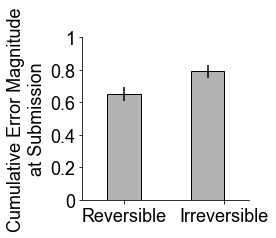

In [17]:
%matplotlib inline

plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': font_size})
    
    
plt.bar(1, np.mean(cum_error_UA_UNA[:,0]), yerr=np.std(cum_error_UA_UNA[:,0])/np.sqrt(100), color='0.7', edgecolor = 'k', width=0.4)
plt.bar(2, np.mean(cum_error_UA_UNA[:,1]), yerr=np.std(cum_error_UA_UNA[:,1])/np.sqrt(100), color='0.7', edgecolor = 'k', width=0.4)

# plt.bar([0,1], np.mean(greedy_action, axis=0), yerr=np.std(greedy_action, axis=0)/np.sqrt(100),color=[.7,.7,.7], edgecolor = 'k',)
plt.xticks([1,2.2], ['Reversible', 'Irreversible'])
plt.xlim([0.5,2.5])
# figure title with the fontsize=9
# plt.title('Greedy move on the first action', fontsize=11)

plt.ylim([0,0.9])
plt.yticks(np.arange(0,1.2,0.2), ['0','0.2','0.4','0.6','0.8','1'])

sns.despine()

# y axis p(greedy choice) of the first move
plt.ylabel('Cumulative Error Magnitude\nat Submission')
plt.savefig(out_dir + 'CumulativeErrorMagnitude_atsubmission' + save_mode, dpi=300, bbox_inches='tight')


# y_max = np.mean(cum_error_UA_UNA) + 2*np.max(np.std(cum_error_UA_UNA)/np.sqrt(100))
# y_max = np.mean(cum_error_UA_UNA) + 0.1
# # Add the result to the bar plot
# result = wilcoxon(cum_error_UA_UNA[:,0], cum_error_UA_UNA[:,1])
# result1 = 'p=' + '{:02f}'.format(result.pvalue)
# # plt.text(1.5, y_max, result1, ha='center')

# # Redraw the figure
# fig.canvas.draw()

# plt.savefig(out_dir + 'CumulativeErrorMagnitude_atsubmission_pval.png', dpi=300, bbox_inches='tight')


### at first move

## *first RT

stat=-5.825, p=0.000


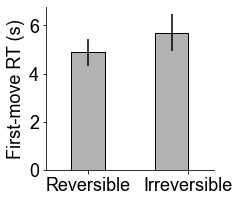

In [18]:
%matplotlib inline

first_RT_ = np.array(first_RT).reshape((-1,2))/1000

# bar plot for first RT
plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': font_size})

plt.bar(1, np.mean(first_RT_[:,0]), yerr=np.std(first_RT_[:,0])/np.sqrt(100), color='0.7', edgecolor = 'k', width=0.4)
plt.bar(2, np.mean(first_RT_[:,1]), yerr=np.std(first_RT_[:,1])/np.sqrt(100), color='0.7', edgecolor = 'k', width=0.4)

plt.xticks([1,2.2], ['Reversible', 'Irreversible'])
plt.xlim([0.5,2.5])


plt.ylabel('First-move RT (s)')

#statistical test
from scipy.stats import ttest_ind
stat,p=ttest_ind(first_RT_[:,0], first_RT_[:,1])
print('stat=%.3f, p=%.3f' % (stat, p))


# remove top and right frame
sns.despine()

# text that says about the p value
# plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# save figure
plt.savefig(out_dir + '/bar_first_RT'+save_mode, dpi=300, bbox_inches='tight')

# save figure
plt.show()

## But only for undo option is not used

## Error rate in the first tryout (matched puzzles)

## *cum error in the first tryout (matched puzzles, matched length)

In [19]:
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

cumerror_first_tryout = []


for sub in range(100):
    
    print('sub{}'.format(sub))

    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic  = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    cumerror_first_tryout_puzzle = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        TS = map[pzi]

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        # get distance from TS['xy'][0] to TS['xy'][1:]
        start = np.array(TS['xy'][0])
        # distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy'][1:]]
        distance = [np.sum(np.sqrt((start - np.array(node))**2)) for node in TS['xy']]

        # find the index that is second shortest distance because the first shortest is goint back to itself
        idx = np.argsort(distance)[1]
        
        # if firstUndo is != 0
        if dat_sbj_undo_pzi['undo'].sum() == 0:
            cumerror_first_tryout_puzzle.append([np.nan, np.nan])
        else:
            idx_firstUndo = np.where(dat_sbj_undo_pzi['firstUndo']==1)[0]
            if len(idx_firstUndo) > 1:
                idx_firstUndo = idx_firstUndo[0]
                
            idx_submit = np.where(dat_sbj_basic_pzi['submit']==1)[0]
            if len(idx_submit) == 0:
                idx_submit = len(dat_sbj_basic_pzi)+1
                
            idx_ = min(idx_firstUndo-1, idx_submit-1)
            
            error_FT_UA = dat_sbj_undo_pzi['currMas'][0].item()-dat_sbj_undo_pzi['currMas'][idx_].item()            

            error_UNA = dat_sbj_basic_pzi['currMas'][0].item()-dat_sbj_basic_pzi['currMas'][idx_].item()
            
            cumerror_first_tryout_puzzle.append([error_FT_UA, error_UNA])
            
            # print([error_rate_FT_UA, error_rate_UNA])

    
    cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
    print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))

cumerror_first_tryout = np.array(cumerror_first_tryout)



sub0
[1.26666667 1.33333333]
sub1
[1.02702703 0.45945946]
sub2
[0.7027027  0.83783784]
sub3
[0.94117647 0.76470588]
sub4
[1.13043478 0.56521739]
sub5
[0.66666667 0.66666667]
sub6
[0.95454545 0.77272727]
sub7
[0.92857143 0.57142857]
sub8
[1.25 0.5 ]
sub9
[1.45454545 0.63636364]
sub10
[1.6 0.6]
sub11
[1.55555556 0.88888889]
sub12
[2. 1.]
sub13
[1.25  0.625]
sub14
[0.70833333 0.41666667]
sub15
[0.72222222 0.33333333]
sub16
[0.875 1.   ]
sub17
[1.         1.02173913]
sub18
[1.23809524 0.57142857]
sub19
[1.53333333 1.33333333]
sub20
[nan nan]
sub21


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[0.86956522 1.04347826]
sub22
[2.         1.28571429]
sub23
[0.96551724 0.48275862]
sub24
[0.86666667 0.63333333]
sub25


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[nan nan]
sub26
[1.09090909 2.36363636]
sub27
[1. 1.]
sub28
[1.33333333 0.        ]
sub29
[0.42857143 0.31428571]
sub30
[1.66666667 1.        ]
sub31
[nan nan]
sub32


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[1.2 0.9]
sub33
[1.  0.5]
sub34
[1.   0.75]
sub35
[1.0952381 1.0952381]
sub36
[1.   1.25]
sub37
[1.66666667 0.66666667]
sub38
[0.7826087  0.39130435]
sub39
[1.29411765 1.        ]
sub40
[1.4  0.65]
sub41
[1.         0.66666667]
sub42
[1.38888889 0.5       ]
sub43
[1.125  0.6875]
sub44
[1.14285714 0.78571429]
sub45
[0.70588235 0.82352941]
sub46
[nan nan]
sub47


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[0.8125 0.4375]
sub48
[0.83333333 0.66666667]
sub49
[0.5 0. ]
sub50
[3.  2.5]
sub51
[1.33333333 1.33333333]
sub52
[0.92857143 0.71428571]
sub53


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[nan nan]
sub54
[0.95238095 0.71428571]
sub55
[0.72972973 0.2972973 ]
sub56
[0.74285714 0.51428571]
sub57
[0.80952381 0.92857143]
sub58
[1.07692308 0.76923077]
sub59
[2.14285714 0.85714286]
sub60
[1. 2.]
sub61
[1.18181818 0.90909091]
sub62
[0.66666667 0.41025641]
sub63
[1.19230769 1.        ]
sub64
[1.58823529 0.70588235]
sub65
[0.74285714 0.34285714]
sub66


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[nan nan]
sub67
[nan nan]
sub68
[1.  0.5]
sub69
[1.33333333 0.66666667]
sub70
[1.30769231 0.92307692]
sub71
[1.         0.66666667]
sub72
[0.64 0.52]
sub73
[0.91666667 0.5       ]
sub74
[0.95454545 0.86363636]
sub75
[1.04545455 0.59090909]
sub76


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[nan nan]
sub77
[0.85714286 0.85714286]
sub78
[1.22727273 0.63636364]
sub79
[1.  0.5]
sub80
[1.33333333 1.2       ]
sub81
[1.25   0.4375]
sub82
[2.  1.8]
sub83
[1.         0.81818182]
sub84


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[nan nan]
sub85
[1.41025641 1.07692308]
sub86
[1.28571429 1.        ]
sub87
[1.23076923 0.69230769]
sub88
[1.71428571 1.14285714]
sub89
[0.70833333 0.66666667]
sub90
[1.25 1.  ]
sub91
[4. 1.]
sub92
[1.46153846 0.96153846]
sub93
[2. 0.]
sub94
[1. 1.]
sub95
[0.86956522 0.52173913]
sub96
[0.6 0.8]
sub97
[nan nan]
sub98


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:56: RuntimeWarning: Mean of empty slice
  cumerror_first_tryout.append(np.nanmean(cumerror_first_tryout_puzzle, axis=0))
/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_82441/3788618951.py:57: RuntimeWarning: Mean of empty slice
  print(np.nanmean(cumerror_first_tryout_puzzle, axis=0))


[1.25 0.25]
sub99
[0.77272727 0.63636364]


stat=5.540, p=0.000


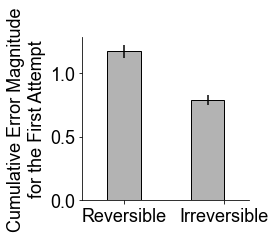

In [20]:
%matplotlib inline

idx_not_nan = ~np.isnan(cumerror_first_tryout).any(axis=1)

# bar plot for first RT
plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': font_size})

plt.bar(1, np.mean(cumerror_first_tryout[idx_not_nan,0]), yerr=np.std(cumerror_first_tryout[idx_not_nan,0])/np.sqrt(len(idx_not_nan)), color='0.7', edgecolor = 'k', width=0.4)
plt.bar(2, np.mean(cumerror_first_tryout[idx_not_nan,1]), yerr=np.std(cumerror_first_tryout[idx_not_nan,1])/np.sqrt(len(idx_not_nan)), color='0.7', edgecolor = 'k', width=0.4)

# plt.xticks([1,2], ['First tryout\nin reversible condition', 'Overall\nin irreversible condition'])
plt.xticks([1,2.2], ['Reversible', 'Irreversible'])
plt.xlim([0.5,2.5])


plt.ylabel('Cumulative Error Magnitude\nfor the First Attempt')

#statistical test
from scipy.stats import ttest_ind
stat,p=ttest_ind(cumerror_first_tryout[idx_not_nan,0], cumerror_first_tryout[idx_not_nan,1])
print('stat=%.3f, p=%.3f' % (stat, p))


# remove top and right frame
sns.despine()

# text that says about the p value
# plt.text(0.5, 0.95, 'p = %.3f' % p, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# save figure
plt.savefig(out_dir + '/cumerror_firsttryout' + save_mode, dpi=300, bbox_inches='tight')

# save figure
plt.show()

# *GLMM between conditions

In [7]:

data_map = pd.DataFrame(columns=['undo_option_used', 'condition_UA', 'cum_error', 'cum_error_FT_OVL', 'first_error', 'firstmoveRT','subject', 'puzzle'])
data_all = pd.DataFrame(columns=['undo_option_used', 'condition_UA', 'cum_error', 'cum_error_FT_OVL', 'first_error', 'firstmoveRT','subject', 'puzzle'])
undo_level = data_choice_level[data_choice_level['condition']==1].copy().reset_index()
basic_level = data_choice_level[data_choice_level['condition']==0].copy().reset_index()

cum_error_UA_UNA = []
first_error_UA_UNA = []
first_RT = []
error_rate_first_tryout = []
cumerror_first_tryout = []


for sub in range(100):
    mas_gain_length = []
    # print('sub{}'.format(sub))
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()

        if dat_sbj_undo_pzi['undo'].sum() == 0:
            error_rate_FT_UA = np.nan
            
            idx_submit = np.where(dat_sbj_basic_pzi['submit']==1)[0]
            if len(idx_submit) == 0:
                idx_submit = len(dat_sbj_basic_pzi)+1
            error_ = dat_sbj_basic_pzi['currMas'][0].item()-dat_sbj_basic_pzi['currMas'][idx_submit-1].item()
            len_ = np.abs(dat_sbj_basic_pzi['currNumCities'][0].item()-dat_sbj_basic_pzi['currNumCities'][idx_submit-1].item())
            error_rate_UNA = error_/len_
            
            cumerror_FT_UA = np.nan
            idx_ = idx_submit-1
            cumerror_UNA = dat_sbj_basic_pzi['currMas'][0].item()-dat_sbj_basic_pzi['currMas'][idx_].item()
            
        else:
        
            idx_firstUndo = np.where(dat_sbj_undo_pzi['firstUndo']==1)[0]
            if len(idx_firstUndo) > 1:
                idx_firstUndo = idx_firstUndo[0]
            error_ = dat_sbj_undo_pzi['currMas'][0].item()-dat_sbj_undo_pzi['currMas'][idx_firstUndo-1].item()
            len_ = np.abs(dat_sbj_undo_pzi['currNumCities'][0].item()-dat_sbj_undo_pzi['currNumCities'][idx_firstUndo-1].item())
            error_rate_FT_UA = error_/len_
                

            idx_submit = np.where(dat_sbj_basic_pzi['submit']==1)[0]
            if len(idx_submit) == 0:
                idx_submit = len(dat_sbj_basic_pzi)+1
            error_ = dat_sbj_basic_pzi['currMas'][0].item()-dat_sbj_basic_pzi['currMas'][idx_submit-1].item()
            len_ = np.abs(dat_sbj_basic_pzi['currNumCities'][0].item()-dat_sbj_basic_pzi['currNumCities'][idx_submit-1].item())
            error_rate_UNA = error_/len_
            
            
                
            idx_ = min(idx_firstUndo-1, idx_submit-1)
            
            cumerror_FT_UA = dat_sbj_undo_pzi['currMas'][0].item()-dat_sbj_undo_pzi['currMas'][idx_].item()            
            cumerror_UNA = dat_sbj_basic_pzi['currMas'][0].item()-dat_sbj_basic_pzi['currMas'][idx_].item()
            
        
        

        
        idx_not_undo = dat_sbj_undo_pzi[dat_sbj_undo_pzi['undo']==0].index
        data_all = pd.concat([data_all, pd.DataFrame([{
                                        'puzzle': pzi,
                                        'subject': sub,
                                        'condition_UA': 0, # undo not allowed
                                        'cum_error':np.abs(dat_sbj_basic_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[0]),
                                        'first_error':np.abs(dat_sbj_basic_pzi['currMas'].iloc[1] - dat_sbj_basic_pzi['currMas'].iloc[0]),
                                        'firstmoveRT':dat_sbj_basic_pzi['RT'].iloc[1]/1000,
                                        'undo_option_used':np.sign(dat_sbj_basic_pzi['undo'].sum()),
                                        'error_rate_FT_OVL':error_rate_UNA,
                                        'cum_error_FT_OVL':cumerror_UNA
                                    }])], ignore_index=True)
        data_all = pd.concat([data_all, pd.DataFrame([{
                                    'puzzle': pzi,
                                    'subject': sub,
                                    'condition_UA': 1, # undo allowed
                                    'cum_error':np.abs(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_undo_pzi['currMas'].iloc[0]),
                                    'first_error':np.abs(dat_sbj_undo_pzi['currMas'].iloc[1] - dat_sbj_undo_pzi['currMas'].iloc[0]),
                                    'firstmoveRT':dat_sbj_undo_pzi['RT'].iloc[1]/1000,
                                    'undo_option_used':np.sign(dat_sbj_undo_pzi['undo'].sum()),
                                    'error_rate_FT_OVL':error_rate_FT_UA,
                                    'cum_error_FT_OVL':cumerror_FT_UA
                                    }])], ignore_index=True)
        

In [8]:
data_all = data_all.copy()
data_all['subject'] = data_all['subject'].astype('int32')
data_all['puzzle'] = data_all['puzzle'].astype('int32')
data_all['condition_UA'] = data_all['condition_UA'].astype('int32')
data_all['undo_option_used'] = data_all['undo_option_used'].astype('int32')
data_all['cum_error'] = data_all['cum_error'].astype('float64')
data_all['cum_error_FT_OVL'] = data_all['cum_error_FT_OVL'].astype('float64')
data_all['first_error'] = data_all['first_error'].astype('float64')
data_all['firstmoveRT'] = data_all['firstmoveRT'].astype('float64')

# save data_all into a csv
data_all.to_csv(R_out_dir + '/dk_stats.csv', index=False)

## *Cumulative error magnitude at submission

In [16]:
%%R -i data_all

data_all$subject <- as.factor(data_all[,"subject"])
data_all$puzzle <- as.factor(data_all[,"puzzle"])
data_all$condition_UA <- as.factor(data_all[,"condition_UA"])

model = lme4::glmer(cum_error ~ condition_UA + (1|subject) + (1|puzzle), data=data_all, family=poisson)

summary(model)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: cum_error ~ condition_UA + (1 | subject) + (1 | puzzle)
   Data: data_all

     AIC      BIC   logLik deviance df.resid 
 18349.0  18377.5  -9170.5  18341.0     9196 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8011 -0.6437 -0.3726  0.4597  8.0746 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.1689   0.4110  
 puzzle  (Intercept) 0.2776   0.5269  
Number of obs: 9200, groups:  subject, 100; puzzle, 46

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.45421    0.08985  -5.055 4.30e-07 ***
condition_UA1 -0.19240    0.02457  -7.830 4.86e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
conditn_UA1 -0.124


## Error rate in first-tryout in the undo allowed versus matched puzzle.

## *Cum error mag in first-tryout in the undo allowed versus matched puzzle.

In [17]:
%%R

# data_all$subject <- as.factor(data_all[,"subject"])
# data_all$puzzle <- as.factor(data_all[,"puzzle"])

model = lme4::glmer(cum_error_FT_OVL ~ condition_UA + (1|subject) + (1|puzzle), data=data_all, family=poisson)

summary(model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: cum_error_FT_OVL ~ condition_UA + (1 | subject) + (1 | puzzle)
   Data: data_all

     AIC      BIC   logLik deviance df.resid 
 13124.3  13151.1  -6558.2  13116.3     6016 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9935 -0.6737 -0.1853  0.4306  8.0119 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.09733  0.3120  
 puzzle  (Intercept) 0.25343  0.5034  
Number of obs: 6020, groups:  subject, 100; puzzle, 46

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.42311    0.08271  -5.116 3.13e-07 ***
condition_UA1  0.34918    0.03317  10.528  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
conditn_UA1 -0.108


## *first RT

In [42]:
%%R

model = lme4::glmer(firstmoveRT ~ condition_UA + (1|subject) + (1|puzzle), data=data_all)

summary(model)


Linear mixed model fit by REML ['lmerMod']
Formula: log(firstmoveRT) ~ condition_UA + (1 | subject) + (1 | puzzle)
   Data: data_all

REML criterion at convergence: 14708.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1772 -0.6608 -0.0943  0.5608  7.9195 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.12491  0.3534  
 puzzle   (Intercept) 0.01856  0.1362  
 Residual             0.27412  0.5236  
Number of obs: 9200, groups:  subject, 100; puzzle, 46

Fixed effects:
              Estimate Std. Error t value
(Intercept)    1.45275    0.04138  35.109
condition_UA1 -0.09619    0.01092  -8.811

Correlation of Fixed Effects:
            (Intr)
conditn_UA1 -0.132


## based on undo option used

# supplementary figure - greedy / optimal move

# Across Maps of different MAS

## number of undos

## total RT

## error magnitude

# between conditions


### error magnitude but where people undid

### error magnitude but where people did not undo

## Optimality first move

## leftover

## RTs

## time taken

## first RT

#  puzzle MAS

## Average first-move RT & Average layer-move RT versus

## submit RT

# between conditions

## calculate time for a puzzle that is matched

# Whisker plot with pairwise comparison

(undo not allowed / undo allowed) x (full / undo option used / undo option not used)

cumulative error magnitude

first move optimality

first move RT


### error magnitude for the first actions

NameError: name 'RT_UA' is not defined

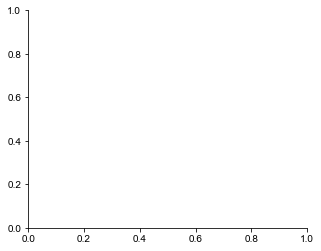

In [21]:
# figure that has 6 bar plots in one figure
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 4))

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

idx1 = np.where(~np.isnan(RT_UA[:,1]))[0]
idx2 = np.where(~np.isnan(RT_UA[:,2]))[0]

# Calculate the mean and SEM
mean_UA_UNA = [np.nanmean(RT_UA[idx1, 1]), np.nanmean(RT_UNA[idx1, 1]),
               np.nanmean(RT_UA[idx2, 2]), np.nanmean(RT_UNA[idx2, 2]),]
sem_UA_UNA = [np.nanstd(RT_UA[idx1, 1])/np.sqrt(len(idx1)), np.nanstd(RT_UNA[idx1, 1])/np.sqrt(len(idx1)),
                np.nanstd(RT_UA[idx2, 2])/np.sqrt(len(idx2)), np.nanstd(RT_UNA[idx2, 2])/np.sqrt(len(idx2)),]

# Set the x and y values
x = [3.5, 4.5, 5.5, 6.5]

# Create the bar plot with error bars
ax.bar(x, mean_UA_UNA, yerr=sem_UA_UNA, color=['1', '0.7', '1', '0.7'], edgecolor='black')

# set xticks only 2 and 2+3.5
ax.set_xticks([4, 6], ['Undo option used','Undo option not used'], fontsize=11)
sns.despine()

# set ylim
ax.set_ylim([0, 3.5])
ax.set_yticks([0, 1, 2, 3], ['0', '1', '2', '3'])

# ylabel
ax.set_ylabel('Average move RT (s)')

#savefigure
plt.savefig(out_dir + 'RT_full_undoused_notused.png', dpi=300, bbox_inches='tight')

from scipy.stats import wilcoxon

# Perform the Wilcoxon signed-rank test
w, p = wilcoxon(RT_UA[idx1, 1], RT_UNA[idx1, 1])
w2, p2 = wilcoxon(RT_UA[idx2, 2], RT_UNA[idx2, 2])

# Indicate the result with '*' or 'n.s.'
result1 = '*' if p < 0.05 else '**' if p < 0.01 else '***' if p < 0.001 else 'n.s.'
result2 = '*' if p2 < 0.05 else '**' if p2 < 0.01 else '***' if p2 < 0.001 else 'n.s.'

y_max = np.max(np.array(mean_UA_UNA[:2]) + np.array(sem_UA_UNA[:2])) + 2*np.max(sem_UA_UNA[:2])
# Add the result to the bar plot
t1 = ax.text(4,y_max, result1, ha='center')
pp1 = ax.plot([3.5, 4.5], [y_max,y_max], color='black')

y_max = np.max(np.array(mean_UA_UNA[2:]) + np.array(sem_UA_UNA[2:])) + 2*np.max(sem_UA_UNA[2:])
t2 = ax.text(6, y_max, result2, ha='center')
pp2 = ax.plot([5.5, 6.5], [y_max,y_max], color='black')

# Redraw the figure
fig.canvas.draw()

plt.savefig(out_dir + 'RT_full_undoused_notused_asterisk.png', dpi=300, bbox_inches='tight')

# remove t1, t2, p1, p2
t1.remove()
t2.remove()
pp1[0].remove()
pp2[0].remove()


# Indicate the result with '*' or 'n.s.'
result1 = 'n.s.' if p > 0.05 else 'p={:0.5f}'.format(p) if p > 0.00001 else 'p<0.00001'
result2 = 'n.s.' if p2 > 0.05 else 'p={:0.5f}'.format(p2) if p2 > 0.00001 else 'p<0.00001'

y_max = np.max(np.array(mean_UA_UNA[:2]) + np.array(sem_UA_UNA[:2])) + 2*np.max(sem_UA_UNA[:2])
# Add the result to the bar plot
ax.text(4,y_max, result1, ha='center')
# ax.plot([3.5, 4.5], [y_max,y_max], color='black')

y_max = np.max(np.array(mean_UA_UNA[2:]) + np.array(sem_UA_UNA[2:])) + 2*np.max(sem_UA_UNA[2:])
ax.text(6, y_max, result2, ha='center')

# Redraw the figure
fig.canvas.draw()

plt.savefig(out_dir + 'RT_full_undoused_notused_pvalue.png', dpi=300, bbox_inches='tight')

# statistical test for behavioral measures

# statistical test for behavioral measures


        data_cond1_outcome = data_cond1_outcome.append({'cumulativeError': cumulativeError, 'firstMoveOptimality': firstMoveOptimality, 'firstMoveRT': firstMoveRT, 'condition': condition, 'puzzleID': puzzleID, 'subjects': subjects, 'undoUsed': undoUsed}, ignore_index=True)

Significnat intercept: mindset effect

why positive effect of undo used? : maybe from they used undo when inherently they make more errors.
then how to solve it?

puzzleMAS?
but in that case we should deal with the correlated puzzleMAS nad puzzleID. which is called colinearity issue
"model struggles to separate the effects of puzzle MAS from the random effects of puzzle ID"



Three categories (Dongqi suggestion)

# *Number of connected cities (map by map)

In [21]:
import os
# os.makedirs(out_dir2, exist_ok=True)

nct_cond_versus_cond = []

# for each subject
for sbj in range(100):
    # for puzzle
    dat_sbj_undo  = undo_level[undo_level['subjects']==sbj].sort_values(["puzzleID","index"])
    dat_sbj_basic = basic_level[basic_level['subjects']==sbj].sort_values(["puzzleID","index"])
    
    nct_sub = []

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()
        
        nct_sub.append([dat_sbj_basic_pzi['currNumCities'].iloc[-1], dat_sbj_undo_pzi['currNumCities'].iloc[-1]])
    
    nct_cond_versus_cond.append(nct_sub)
    
nct_cond_versus_cond = np.array(nct_cond_versus_cond)
        

In [22]:
mean_cond = np.mean(nct_cond_versus_cond, axis=0)
sem_cond = np.std(nct_cond_versus_cond, axis=0) / np.sqrt(nct_cond_versus_cond.shape[0])
print(sem_cond.shape)

(46, 2)


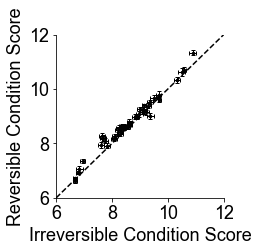

In [27]:
%matplotlib inline
plt.rcParams.update({'font.size': font_size})
mean_cond = np.mean(nct_cond_versus_cond, axis=0)
sem_cond = np.std(nct_cond_versus_cond, axis=0) / np.sqrt(nct_cond_versus_cond.shape[0])
fig, ax = plt.subplots(figsize=(3, 3))


# # font size of the figure
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

# scatter plot with x and y error bars that are sem_cond[:,0] and sem_cond[:,1]
ax.errorbar(mean_cond[:,0], mean_cond[:,1], xerr=sem_cond[:,0], yerr=sem_cond[:,1], fmt='.', color='black', ecolor='black', elinewidth=1, capsize=2, markersize=5)

# plot the line y=x
ax.plot([6, 12], [6, 12], color='black', linestyle='--')

# xlim ylim
ax.set_xlim([6, 12])
ax.set_ylim([6, 12])

# xticks ans yticks
ax.set_xticks([6, 8, 10, 12])
ax.set_yticks([6, 8, 10, 12])

# xtitle ytitle
ax.set_xlabel('Irreversible Condition Score')
ax.set_ylabel('Reversible Condition Score')

# save figure
plt.savefig(out_dir + 'num_cities_score_scatter' + save_mode, dpi=300, bbox_inches='tight')


# *Redo



## different city (undo target)

In [28]:
undo_ = []
for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo__ = []
    for pzi in np.unique(dat_sbj['puzzleID']):
        undo_num = dat_sbj['undo'].sum()
        undo__.append(undo_num)
    undo_.append(undo__)
np.array(undo_).sum(axis=1)

array([ 9292,  8878, 24564, 14352,  6808,   276,  6808,  3542,   552,
        7866,   322,  1702,    46,  3128, 11316,  5060,  1794,  2438,
        5750,  5888,     0,  7038,  2760, 10166, 15226,     0,   506,
          46,   138, 18676,   414,     0,  1702,    92,   184,  2024,
        1334,  2898,  5520,  4922,  6900,  4692,  5106,  8740,  5704,
        6394,     0,  5428,  5014,   276,   506,   874,  5382,     0,
        6026, 31372, 16652,  1932,  2990,  1610,   276,  3266, 38180,
        7038,  3496, 24058,     0,     0,   920,  1150,  6164,   598,
       22908,  4968,  8280,  9338,     0,   460,  9108,   598,  5888,
        5244,  1012,  4876,     0,  3864,  3634,  3082,  4278, 16054,
        1610,   184,  3404,    46,    46,  9890,  8004,     0,   414,
        7406])

In [29]:
undo_same_diff = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    undo_same_diff_puzzle = []
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        same_puzzle = 0
        diff_puzzle = 0

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx)
        idxx = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx)

        undo_same_diff_puzzle.append([same_puzzle, diff_puzzle])
    undo_same_diff_puzzle =  np.array(undo_same_diff_puzzle)
    undo_same_diff_puzzle =  np.sum(undo_same_diff_puzzle,axis=0)

    if np.sum(undo_same_diff_puzzle)==0:
        print(sub) # who does not undo

    undo_same_diff.append(undo_same_diff_puzzle)

undo_same_diff = np.array(undo_same_diff)

20
25
31
46
53
66
67
76
84
97


In [30]:
# exclude some never undoing subjects
undo_same_diff = undo_same_diff[np.where(np.sum(np.array(undo_same_diff),axis=1)!=0),:]
undo_same_diff = undo_same_diff.squeeze()
undo_same_diff_p = undo_same_diff/ np.sum(undo_same_diff,axis = 1)[:,None]

## *( same x different ) x ( better, equally good, worse )

In [31]:
sub = 0
dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
pzi = 1

In [32]:
undo_same_diff = []
undo_same_diff_weqb = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    same_puzzle = 0
    same_worse_eq_better = np.array([0,0,0])
    diff_puzzle = 0
    diff_worse_eq_better = np.array([0,0,0])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        idxx_diff = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx_diff)

        idxx_same = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx_same)

        mas_gain = np.array(dat_sbj_pzi["currMas"][lastUndo_idx+1]) - np.array(dat_sbj_pzi["currMas"][lastUndo_idx-1])

        idxx_w  = mas_gain < 0
        idxx_eq = mas_gain == 0
        idxx_b  = mas_gain > 0

        # find intersection between np.where(idxx_diff) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_diff_w = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_w)[0])
        idxx_diff_eq = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_eq)[0])
        idxx_diff_b = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_b)[0])

        diff_worse_eq_better += np.array([len(idxx_diff_w), len(idxx_diff_eq), len(idxx_diff_b)])

        # find intersection between np.where(idxx_same) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_same_w = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_w)[0])
        idxx_same_eq = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_eq)[0])
        idxx_same_b = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_b)[0])

        same_worse_eq_better += np.array([len(idxx_same_w), len(idxx_same_eq), len(idxx_same_b)])

    undo_same_diff_puzzle =  np.array([same_puzzle, diff_puzzle])
    undo_same_diff_weqb_puzzle = np.array([*same_worse_eq_better, *diff_worse_eq_better])

    if np.sum(undo_same_diff_puzzle)==0:
        print(sub) # who does not undo

    undo_same_diff.append(undo_same_diff_puzzle)
    undo_same_diff_weqb.append(undo_same_diff_weqb_puzzle)

undo_same_diff = np.array(undo_same_diff)
undo_same_diff_weqb = np.array(undo_same_diff_weqb)

20
25
31
46
53
66
67
76
84
97


In [33]:
# exclude some never undoing subjects
undo_same_diff_weqb = undo_same_diff_weqb[np.where(np.sum(np.array(undo_same_diff_weqb),axis=1)!=0),:]
undo_same_diff_weqb = undo_same_diff_weqb.squeeze()
undo_same_diff_weqb_p = undo_same_diff_weqb/ np.sum(undo_same_diff_weqb,axis = 1)[:,None]

In [34]:
print(undo_same_diff_weqb.shape)
mean_weqb = np.mean(undo_same_diff_weqb_p*100,axis=0)
sem_weqb = np.std(undo_same_diff_weqb_p*100,axis = 0)/np.sqrt(undo_same_diff_weqb_p.shape[0])
print(f'{mean_weqb} +/- {sem_weqb}')

(90, 6)
[ 0.         11.865547    0.         16.77343593 32.44086827 38.92014881] +/- [0.         1.52078756 0.         1.50678118 2.19481039 2.38408724]


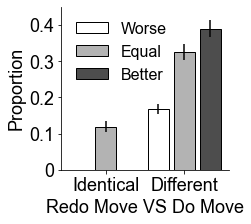

In [37]:
%matplotlib inline

# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12
# bar plot for undo_same_diff_weqb
plt.rcParams.update({'font.size': font_size})
fig, ax = plt.subplots(1,1,figsize=(3,3))
colors = ['w','0.7','0.3']
for each in range(3):
    ax.bar(np.arange(2)*3+each, np.mean(undo_same_diff_weqb_p[:, np.arange(2)*3+each],axis=0), yerr = np.std(undo_same_diff_weqb_p[:, np.arange(2)*3+each],axis=0)/np.sqrt(undo_same_diff_weqb[:, np.arange(2)*3+each].shape[0]), color = colors[each],edgecolor = 'k')


# ax.bar(np.arange(6), np.mean(undo_same_diff_weqb_p,axis=0), yerr = np.std(undo_same_diff_weqb_p,axis=0)/np.sqrt(undo_same_diff_weqb.shape[0]), color = ['w','0.5','k'],edgecolor = 'k')
sns.despine()

# ax.set_xticks(np.arange(6))
# ax.set_xticklabels(['','Same','','','Different',''])

ax.set_xticks([1,4])
ax.set_xticklabels(['Identical','Different'])

# set y lim
ax.set_ylim([0,0.45])

# set y ticks
ax.set_yticks(np.arange(0,0.5,0.1))
# set ytickslabel in string
ax.set_yticklabels(['0','0.1','0.2','0.3','0.4'])

# legend that says worse, equally good, better, without bounding box
ax.legend(['Worse','Equal','Better'],loc='upper left', frameon=False, fontsize = 16)

ax.set_xlabel('Redo Move VS Do Move')
ax.set_ylabel('Proportion')

# save figure
plt.savefig(out_dir + '/figure_worse_better_with_same_diff'+save_mode, dpi=300, bbox_inches='tight')

## *GLMM for better

In [141]:
sub = 9


dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
same_puzzle = 0
same_worse_eq_better = np.array([0,0,0])
diff_puzzle = 0
diff_worse_eq_better = np.array([0,0,0])

pzi = 9

dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
idxx_diff = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
diff_puzzle += np.sum(idxx_diff)
idxx_same = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
same_puzzle += np.sum(idxx_same)
mas_gain = np.array(dat_sbj_pzi["currMas"][lastUndo_idx+1]) - np.array(dat_sbj_pzi["currMas"][lastUndo_idx-1])

print(lastUndo_idx)
print(idxx_diff)
print(idxx_same)

curr_nct = np.array(dat_sbj_pzi["currNumCities"][lastUndo_idx])
curr_mas = np.array(dat_sbj_pzi["currMas"][lastUndo_idx])

print(curr_nct)
print(curr_mas)
max_mas = dat_sbj_pzi['currMas'].iloc[0]
print(max_mas)

Int64Index([2], dtype='int64')
[ True]
[False]
[1]
[10]
10


In [39]:
data_map_ = pd.DataFrame(columns=['Worse_Equal_Better', 'same_diff', 'currMAS', 'currNCT', 'Max_currMAS', 'subject', 'puzzle'])
data_map2_ = pd.DataFrame(columns=['currMPS_ref', 'currMPS', 'currCumError_ref', 'currCumError', 'currMAS', 'currNCT', 'do_redo', 'subject', 'puzzle'])

for sub in trange(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index"])
    same_puzzle = 0
    same_worse_eq_better = np.array([0,0,0])
    diff_puzzle = 0
    diff_worse_eq_better = np.array([0,0,0])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):

        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()
        max_mas = dat_sbj_pzi['currMas'].iloc[0]
        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index
        idxx_diff = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) != np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        diff_puzzle += np.sum(idxx_diff)
        idxx_same = np.array(dat_sbj_pzi["choice"][lastUndo_idx-1]) == np.array(dat_sbj_pzi["choice"][lastUndo_idx+1])
        same_puzzle += np.sum(idxx_same)
        mas_gain = np.array(dat_sbj_pzi["currMas"][lastUndo_idx+1]) - np.array(dat_sbj_pzi["currMas"][lastUndo_idx-1])
        
        curr_nct = np.array(dat_sbj_pzi["currNumCities"][lastUndo_idx])
        curr_mas = np.array(dat_sbj_pzi["currMas"][lastUndo_idx])
        
        for idx in lastUndo_idx:
            # print('do_currMPS_ref', dat_sbj_pzi["currMas"][idx]-dat_sbj_pzi["currMas"][idx-1])
            data_map2_ = pd.concat([data_map2_, pd.DataFrame({'currMPS_ref': [dat_sbj_pzi["currMas"][idx]-dat_sbj_pzi["currMas"][idx-1]], 'currMPS': [dat_sbj_pzi["currMas"][idx-1]],
                                            'currCumError_ref': [(max_mas-dat_sbj_pzi["currMas"][idx-1]) - (max_mas-dat_sbj_pzi["currMas"][idx])], 
                                            'currCumError': [max_mas-dat_sbj_pzi["currMas"][idx-1]], 'currMAS':[dat_sbj_pzi["currMas"][idx-1]], 'currNCT':[dat_sbj_pzi["currNumCities"][idx-1]], 'do_redo':['do'], 'subject':[sub], 'puzzle':[pzi]})], ignore_index=True)
            # print('redo_currMPS_ref', dat_sbj_pzi["currMas"][idx]-dat_sbj_pzi["currMas"][idx+1])
            data_map2_ = pd.concat([data_map2_, pd.DataFrame({'currMPS_ref': [dat_sbj_pzi["currMas"][idx]-dat_sbj_pzi["currMas"][idx+1]],'currMPS': [dat_sbj_pzi["currMas"][idx+1]],
                                            'currCumError_ref': [(max_mas-dat_sbj_pzi["currMas"][idx+1]) - (max_mas-dat_sbj_pzi["currMas"][idx])],
                                            'currCumError': [max_mas-dat_sbj_pzi["currMas"][idx+1]], 'currMAS':[dat_sbj_pzi["currMas"][idx+1]], 'currNCT':[dat_sbj_pzi["currNumCities"][idx+1]], 'do_redo':['redo'], 'subject':[sub], 'puzzle':[pzi]})], ignore_index=True)
                                          
        idxx_w  = mas_gain < 0
        idxx_eq = mas_gain == 0
        idxx_b  = mas_gain > 0

        # find intersection between np.where(idxx_diff) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_diff_w = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_w)[0])
        idxx_diff_eq = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_eq)[0])
        idxx_diff_b = np.intersect1d(np.where(idxx_diff)[0], np.where(idxx_b)[0])
        for idx in idxx_diff_w:
            data_map_ = pd.concat([data_map_, pd.DataFrame({'Worse_Equal_Better': ['Worse'], 'same_diff':['Different'], 'subject':[sub], 'puzzle':[pzi], 'currMAS':[curr_mas[idx]], 'currNCT':[curr_nct[idx]], 'Max_currMAS':[max_mas-curr_mas[idx]]})], ignore_index=True)
        for idx in idxx_diff_eq:
            data_map_ = pd.concat([data_map_, pd.DataFrame({'Worse_Equal_Better': ['Equal'], 'same_diff':['Different'], 'subject':[sub], 'puzzle':[pzi], 'currMAS':[curr_mas[idx]], 'currNCT':[curr_nct[idx]], 'Max_currMAS':[max_mas-curr_mas[idx]]})], ignore_index=True)
        for idx in idxx_diff_b:
            data_map_ = pd.concat([data_map_, pd.DataFrame({'Worse_Equal_Better': ['Better'], 'same_diff':['Different'], 'subject':[sub], 'puzzle':[pzi], 'currMAS':[curr_mas[idx]], 'currNCT':[curr_nct[idx]], 'Max_currMAS':[max_mas-curr_mas[idx]]})], ignore_index=True)
            
            
        # find intersection between np.where(idxx_same) and np.where(idxx_w), np.where(idxx_eq), np.where(idxx_b)
        idxx_same_w = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_w)[0])
        idxx_same_eq = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_eq)[0])
        idxx_same_b = np.intersect1d(np.where(idxx_same)[0], np.where(idxx_b)[0])
        for idx in idxx_same_w:
            data_map_ = pd.concat([data_map_, pd.DataFrame({'Worse_Equal_Better': ['Worse'], 'same_diff':['Same'], 'subject':[sub], 'puzzle':[pzi], 'currMAS':[curr_mas[idx]], 'currNCT':[curr_nct[idx]], 'Max_currMAS':[max_mas-curr_mas[idx]]})], ignore_index=True)
        for idx in idxx_same_eq:
            data_map_ = pd.concat([data_map_, pd.DataFrame({'Worse_Equal_Better': ['Equal'], 'same_diff':['Same'], 'subject':[sub], 'puzzle':[pzi], 'currMAS':[curr_mas[idx]], 'currNCT':[curr_nct[idx]], 'Max_currMAS':[max_mas-curr_mas[idx]]})], ignore_index=True)
        for idx in idxx_same_b:
            data_map_ = pd.concat([data_map_, pd.DataFrame({'Worse_Equal_Better': ['Better'], 'same_diff':['Same'], 'subject':[sub], 'puzzle':[pzi], 'currMAS':[curr_mas[idx]], 'currNCT':[curr_nct[idx]], 'Max_currMAS':[max_mas-curr_mas[idx]]})], ignore_index=True)

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


In [40]:
np.unique(data_map2_['currCumError_ref'].to_numpy())

array([0, 1, 2, 3, 4, 5, 6], dtype=object)

I tried the following but found better one

%%R -i data_map_

data_map_$Worse_Equal_Better <- as.factor(data_map_[,"Worse_Equal_Better"])
data_map_$same_diff <- as.factor(data_map_[,"same_diff"])


model = nnet::multinom(Worse_Equal_Better ~ same_diff + Max_currMAS + (1|subject) + (1|puzzle), data = data_map_)

summary(model)

%%R -i data_map_

data_map_$Worse_Equal_Better <- as.factor(data_map_[,"Worse_Equal_Better"])
data_map_$Worse_Equal_Better <- relevel(data_map_$Worse_Equal_Better, ref = "Worse")
data_map_$same_diff <- as.factor(data_map_[,"same_diff"])
data_map_$same_diff <- relevel(data_map_$same_diff, ref = "Same")


model2 = nnet::multinom(Worse_Equal_Better ~ same_diff + currNCT + currMAS + (1|subject) + (1|puzzle), data = data_map_)

summary_model <- summary(model2)

coefficients <- summary_model$coefficients
standard_errors <- summary_model$standard.errors

wald_z <- coefficients / standard_errors

p_values <- 2 * (1 - pnorm(abs(wald_z)))

summary_model

In [41]:
%%R -i data_map2_

data_map2_$subject <- as.factor(data_map2_$subject)
data_map2_$puzzle <- as.factor(data_map2_$puzzle)
data_map2_$do_redo <- as.factor(data_map2_$do_redo)

model = lme4::glmer(currCumError_ref ~  do_redo + (1 |subject) + (1 |puzzle), data = data_map2_, family = "poisson")

summary(model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: currCumError_ref ~ do_redo + (1 | subject) + (1 | puzzle)
   Data: data_map2_

     AIC      BIC   logLik deviance df.resid 
  8970.5   8996.8  -4481.2   8962.5     5316 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2743 -0.6444 -0.4830  0.5388  8.0707 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.1273   0.3567  
 puzzle  (Intercept) 0.1948   0.4414  
Number of obs: 5320, groups:  subject, 90; puzzle, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.73883    0.08335  -8.864   <2e-16 ***
do_redoredo -0.42707    0.04174 -10.231   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
do_redoredo -0.198



# Overlapped sequence

### overlapped sequence from all of the prev seqs.

### Histogram - length of undone sequence

### How often overlaps with previous paths

####  (including length = 1; which means only a city overlapped)

# first try-out with undo vs without undo

DK: is first try-out in undoing condition worse than without undo condition?


In [160]:
currmas_with_undo = np.nanmean(currmas_with_without_undo[:,:,0],axis=1)
currmas_without_undo = np.nanmean(currmas_with_without_undo[:,:,1],axis=1)
# currmas_without_undo = currmas_with_without_undo[:,:,1].mean(axis=1)

In [161]:
[np.nanmean(currmas_with_undo), np.nanmean(currmas_without_undo)]

[8.698260869565217, 8.728478260869567]

# redoing after undoing

some of the plots with fixed length of undone path

In [165]:
import copy
def get_tortuosity(pathList, pzi = 15):
    def cal_dist(xy1, xy2):
        return np.sqrt(np.sum((np.array(xy1)-np.array(xy2))**2))

    pathList_ = copy.deepcopy(pathList)

    ### for the def
    import json
    with open('./util/basicMap.json','rb') as f:
        basic_map = json.load(f)
    tortuosity = []
    ###

    map_pz = basic_map[pzi]

    import numpy as np
    for _ in range(len(pathList_)):
        path = pathList_.pop(0)
        if len(path)>1:
            ct_init = path.pop(0)
#             print(path)
#             print('init{}_tgt{}'.format(ct_init, path[-1]))
#             print('map_init{}_map_tgt{}'.format(map_pz['xy'][ct_init], map_pz['xy'][path[-1]]))
            d_straight = cal_dist(map_pz['xy'][ct_init], map_pz['xy'][path[-1]])
            d_zigzag = 0
            for _ in range(len(path)):
                ct_tgt = path.pop(0)
                d_zigzag += cal_dist(map_pz['xy'][ct_init], map_pz['xy'][ct_tgt])
                ct_init = ct_tgt
            tortuosity.append([d_zigzag, d_straight])
        else:
            tortuosity.append([np.nan, np.nan])
    return np.array(tortuosity)


In [166]:
data_ = []
data_firstundo_ = []
data_overlap_inorder = []
data_overlap_inorder_p = []
data_overlap_rglssorder = []
data_overlap_rglssorder_p = []
data_mas_123 = []
data_currmas_123 = []
data_nct_123 = []
data_undo_redo_RT = []
data_mas_for_errorrate = []

for sub in range(100):
    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    data_puzzle = []
    data_puzzle_firstundo = []
    data_overlap_inorder_puzzle = []
    data_overlap_inorder_p_puzzle = []
    data_overlap_rglssorder_puzzle = []
    data_overlap_rglssorder_p_puzzle = []
    data_mas_123_puzzle = []
    data_currmas_123_puzzle = []
    data_nct_123_puzzle = []
    data_undo_redo_RT_puzzle = []
    data_mas_for_errorrate_puzzle = []

    print(sub)

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"] == 1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx - 1]  # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"] == 1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx + 1]  # the mas of the state after undo

        submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])

        if len(firstUndo_idx) > 0:
            if len(firstUndo_idx) == 1:  #
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]


            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]

            seq_im = seq_im.reset_index()
            pathStr_im = [seq_im.loc[i].path.strip('[').strip(']') for i in range(len(seq_im))]
            pathList_im = [[int(i) for i in pathStr_im[j].split(', ')]  for j in range(len(pathStr_im))]
            pathStr_im = [" ".join([str(a) for a in pathList_im[j]]) for j in range(len(seq_im))]

            seq_bf = seq_bf.reset_index()
            pathStr_bf = [seq_bf.loc[i].path.strip('[').strip(']') for i in range(len(seq_bf))]
            pathList_bf = [[int(i) for i in pathStr_bf[j].split(', ')]  for j in range(len(pathStr_bf))]
            pathStr_bf = [" ".join([str(a) for a in pathList_bf[j]]) for j in range(len(seq_bf))]

            seq_af = seq_af.reset_index()
            pathStr_af = [seq_af.loc[i].path.strip('[').strip(']') for i in range(len(seq_af))]
            pathList_af = [[int(i) for i in pathStr_af[j].split(', ')]  for j in range(len(pathStr_af))]
            pathStr_af = [" ".join([str(a) for a in pathList_af[j]]) for j in range(len(seq_af))]

            firstundoidx = firstUndo_idx.to_numpy()-1
            lastundoidx = lastUndo_idx.to_numpy()
            tidx = np.array(t_idx) + 1
            tidx[-1] -= 1

            length_firstundo_mas_tortuosity = []
            length_mas_123 = []
            length_currmas_123 = []
            length_nct_123 = []
            length_undo_redo_RT = []
            length_mas_for_errorrate = []


            length_mas_tortuosity = []
            length_inorder_p = []
            length_inorder = []
            length_rglssorder_p = []
            length_rglssorder = []
            for i in range(len(firstundoidx)):
                currnct = dat_sbj_pzi["currNumCities"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct2 = currnct.copy()
                currmas = dat_sbj_pzi["currMas"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct = currnct - min(currnct)
                currpath = dat_sbj_pzi["path"][firstundoidx[i]:tidx[i]].to_list()
                currpath = [currpath[i].strip('[').strip(']') for i in range(len(currpath))]
                currpath = [[int(i) for i in currpath[j].split(', ')] for j in range(len(currpath))]

                currRT = dat_sbj_pzi["RT"][firstundoidx[i]:tidx[i]].to_numpy()
                currundoRT = dat_sbj_pzi["undoRT"][firstundoidx[i]:tidx[i]].to_numpy()

                seq_im = dat_sbj_pzi["path"][lastundoidx[i]]
                pathStr_im = seq_im.strip('[').strip(']')
                pathList_im = [int(i) for i in pathStr_im.split(', ')]

                currpath = [np.setdiff1d(currpath[i], pathList_im).tolist() for i in range(len(currpath))]
                pathafter = [np.setdiff1d(pathList_af[i], pathList_im).tolist() for i in range(len(pathList_af))]

                # return nan if length of list is smaller than 1 or eqaul to 1, otherwise return get_tortuosity
                tortuosity = [np.nan if len(currpath[i])<2 else get_tortuosity([currpath[i]], pzi) for i in range(len(currpath))]
                # update tortuosity if the element is not nan, devide first number with the second number
                tortuosity = [tortuosity[i][0][0]/tortuosity[i][0][1] if np.all(np.isnan(tortuosity[i]))==False else np.nan for i in range(len(tortuosity))]

                for j in range(1,9):
                    # return index of currnct is equal to i
                    idx = np.where(currnct==j)[0]

                    if len(idx)<2:
                        length_mas_tortuosity.append([j, np.nan, np.nan])
                        length_mas_123.append([j, np.nan, np.nan, np.nan])
                        length_currmas_123.append([j, np.nan, np.nan, np.nan])
                        length_nct_123.append([j, np.nan, np.nan, np.nan])
                        length_undo_redo_RT.append([j, np.nan, np.nan]) # j, undoing RT, redoing RT
                        length_firstundo_mas_tortuosity.append([j,dat_sbj_pzi["currMas"][0], np.nan, np.nan])
                        length_rglssorder.append([j, np.nan])
                        length_rglssorder_p.append([j, np.nan])
                        length_inorder.append([j, np.nan])
                        length_inorder_p.append([j, np.nan])

                        length_mas_for_errorrate.append([j, np.nan, np.nan, np.nan, dat_sbj_pzi["currMas"][0]])
                    else:
                        length_mas_tortuosity.append([j, currmas[idx[1]]-currmas[idx[0]], tortuosity[idx[1]]-tortuosity[idx[0]]])
                        length_firstundo_mas_tortuosity.append([j,dat_sbj_pzi["currMas"][0], currmas[idx[1]]-currmas[idx[0]], tortuosity[idx[1]]-tortuosity[idx[0]]])
                        idx_2 = np.where(currnct==0)[0]
                        # if len(idx_2)==2 then select the first one
                        if len(idx_2)==2:
                            idx_2 = idx_2[0]
                        else:
                            idx_2 = idx_2.item()
                        currmas2 = currmas[idx_2].item()

                        length_mas_123.append([j,currmas2 - currmas[idx[0]], currmas2-currmas[idx[1]], currmas[idx[1]]-currmas[idx[0]]]) # 2-1 3-2 3-1

                        length_currmas_123.append([j, currmas[idx[0]]-dat_sbj_pzi["currMas"][0], currmas2 - dat_sbj_pzi["currMas"][0], currmas[idx[1]]-dat_sbj_pzi["currMas"][0]]) # 1, 2, 3

                        length_mas_for_errorrate.append([j, currmas[idx[0]], currmas2, currmas[idx[1]], dat_sbj_pzi["currMas"][0]])

                        length_nct_123.append([j, currnct2[idx[0]], currnct2[idx_2], currnct2[idx[1]]]) # 1, 2, 3

                        length_undo_redo_RT.append([j, np.sum(currRT[idx[0]+1:idx_2+1]), np.sum(currRT[idx_2+1:idx[1]+1])])


                        temp = get_overlaplist(currpath[idx[0]],currpath[idx[1]])
                        temp = trimmer(temp)
                        if len(temp)==0:
                            temp.append([])
                        overlap_num_city_ = 0
                        for seq in temp:
                            overlap_num_city_ += len(seq)
                        len_seq_inorder_2 =[]
                        tempcurd = []
                        for s in temp:
                            if len(s)==0:
                                len_seq_inorder_2.append(0)
                            else:
                                len_seq_inorder_2.append(len(s))
                        for element in len_seq_inorder_2:
                            length_inorder_p.append([j,element/len(currpath[idx[1]])])
                            length_inorder.append([j,element])
                        length_rglssorder_p.append([j,overlap_num_city_/len(currpath[idx[1]])])
                        length_rglssorder.append([j,overlap_num_city_])
            data_puzzle.append(length_mas_tortuosity)
            data_puzzle_firstundo.append(length_firstundo_mas_tortuosity)
            data_overlap_inorder_p_puzzle.append(length_inorder_p)
            data_overlap_inorder_puzzle.append(length_inorder)
            data_overlap_rglssorder_p_puzzle.append(length_rglssorder_p)
            data_overlap_rglssorder_puzzle.append(length_rglssorder)
            data_mas_123_puzzle.append(length_mas_123)
            data_currmas_123_puzzle.append(length_currmas_123)
            data_nct_123_puzzle.append(length_nct_123)
            data_undo_redo_RT_puzzle.append(length_undo_redo_RT)
            data_mas_for_errorrate_puzzle.append(length_mas_for_errorrate)

    data_.append(data_puzzle)
    data_firstundo_.append(data_puzzle_firstundo)
    data_overlap_inorder_p.append(data_overlap_inorder_p_puzzle)
    data_overlap_inorder.append(data_overlap_inorder_puzzle)
    data_overlap_rglssorder_p.append(data_overlap_rglssorder_p_puzzle)
    data_overlap_rglssorder.append(data_overlap_rglssorder_puzzle)
    data_mas_123.append(data_mas_123_puzzle)
    data_currmas_123.append(data_currmas_123_puzzle)
    data_nct_123.append(data_nct_123_puzzle)

    data_undo_redo_RT.append(data_undo_redo_RT_puzzle)
    data_mas_for_errorrate.append(data_mas_for_errorrate_puzzle)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [167]:
mas_gain = []
for sub in range(100):
    mas_gain_length = []
    print('sub{}'.format(sub))
    dat_sbj_undo  = undo_level[undo_level['subjects']==sub].sort_values(["puzzleID","index"])
    dat_sbj_basic = basic_level[basic_level['subjects']==sub].sort_values(["puzzleID","index"])

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_undo_pzi = dat_sbj_undo[dat_sbj_undo['puzzleID'] == pzi].reset_index()
        dat_sbj_basic_pzi = dat_sbj_basic[dat_sbj_basic['puzzleID'] == pzi].reset_index()

        mas_gain_length.append(dat_sbj_undo_pzi['currMas'].iloc[-1] - dat_sbj_basic_pzi['currMas'].iloc[-1])
    mas_gain.append(mas_gain_length)
mas_gain = np.array(mas_gain)

sub0
sub1
sub2
sub3
sub4
sub5
sub6
sub7
sub8
sub9
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub17
sub18
sub19
sub20
sub21
sub22
sub23
sub24
sub25
sub26
sub27
sub28
sub29
sub30
sub31
sub32
sub33
sub34
sub35
sub36
sub37
sub38
sub39
sub40
sub41
sub42
sub43
sub44
sub45
sub46
sub47
sub48
sub49
sub50
sub51
sub52
sub53
sub54
sub55
sub56
sub57
sub58
sub59
sub60
sub61
sub62
sub63
sub64
sub65
sub66
sub67
sub68
sub69
sub70
sub71
sub72
sub73
sub74
sub75
sub76
sub77
sub78
sub79
sub80
sub81
sub82
sub83
sub84
sub85
sub86
sub87
sub88
sub89
sub90
sub91
sub92
sub93
sub94
sub95
sub96
sub97
sub98
sub99


In [168]:
mas = []
tortuosity = []

mas_atend = []
tortuosity_atend = []

overlap_inlen_p = []
overlap_rglss_p = []

overlap_inlen = []
overlap_rglss = []

for sub in range(100):
    mas_length_puzzle = []
    tortuosity_puzzle = []

    mas_length_atend_puzzle = []
    tortuosity_atend_puzzle = []


    overlap_inorder_p_puzzle = []
    overlap_inorder_puzzle = []
    overlap_rglssorder_p_puzzle = []
    overlap_rglssorder_puzzle = []

    for minlen in range(1,9):
        mas_length_atend_minlen = []
        tortuosity_atend_minlen = []

        mas_length_minlen = []
        tortuosity_minlen = []

        overlap_inorder_p_minlen  = []
        overlap_inorder_minlen    = []
        overlap_rglssorder_p_minlen  = []
        overlap_rglssorder_minlen    = []



        for pzi in range(len(data_[sub])):
            data_puzzle = np.array(data_[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to minlen
            idx_ = np.where(data_puzzle[:,0]==minlen)[0]

            mas_length_minlen.extend(data_puzzle[idx_,1])
            tortuosity_minlen.extend(data_puzzle[idx_,2])


            data_overlap_inorder_puzzle = np.array(data_overlap_inorder[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_inorder_puzzle[:,0]==minlen)[0]
            overlap_inorder_minlen.extend(np.array(data_overlap_inorder_puzzle[idx_,1:]))

            data_overlap_rglssorder_puzzle = np.array(data_overlap_rglssorder[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_rglssorder_puzzle[:,0]==minlen)[0]
            overlap_rglssorder_minlen.extend(np.array(data_overlap_rglssorder_puzzle[idx_,1:]))

            data_overlap_inorder_p_puzzle = np.array(data_overlap_inorder_p[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_inorder_p_puzzle[:,0]==minlen)[0]
            overlap_inorder_p_minlen.extend(np.array(data_overlap_inorder_p_puzzle[idx_,1:]))

            data_overlap_rglssorder_p_puzzle = np.array(data_overlap_rglssorder_p[sub][pzi]).copy()

            # find data_puzzle with column[0] is equal to 5, 6 ,7
            idx_ = np.where(data_overlap_rglssorder_p_puzzle[:,0]==minlen)[0]
            overlap_rglssorder_p_minlen.extend(np.array(data_overlap_rglssorder_p_puzzle[idx_,1:]))

            data_puzzle = np.array(data_[sub][pzi]).copy()
            # data puzzle that has no nan
            data_puzzle = data_puzzle[~np.isnan(data_puzzle[:,1]),:]

            idxes = np.where(data_puzzle[np.arange(1,data_puzzle.shape[0]),0] < data_puzzle[np.arange(0,data_puzzle.shape[0]-1),0])[0]
            #concatenate idxes with the last index of data_puzzle
            idxes = np.concatenate((idxes,np.array([data_puzzle.shape[0]-1])))

            # print(idxes)
            # print(data_puzzle)
            # print('*'*10)
            #idxes that is not nan in data_puzzle
            # idxes = np.where(~np.isnan(data_puzzle[:,1]))[0]

            # print(idxes)

            idx_ = np.where(data_puzzle[:,0]==minlen)[0]
            # intersect idxes and idx_
            idxes = np.intersect1d(idxes,idx_)

            mas_length_atend_minlen.extend(data_puzzle[idxes,1])
            tortuosity_atend_minlen.extend(data_puzzle[idxes,2])

        if len(overlap_inorder_minlen)==0:
            overlap_inorder_puzzle.append([np.nan])
        else:
            overlap_inorder_puzzle.append(np.nanmean(overlap_inorder_minlen,axis=0))

        if len(overlap_rglssorder_minlen)==0:
            overlap_rglssorder_puzzle.append([np.nan])
        else:
            overlap_rglssorder_puzzle.append(np.nanmean(overlap_rglssorder_minlen,axis=0))

        if len(overlap_inorder_p_minlen)==0:
            overlap_inorder_p_puzzle.append([np.nan])
        else:
            overlap_inorder_p_puzzle.append(np.nanmean(overlap_inorder_p_minlen,axis=0))

        if len(overlap_rglssorder_p_minlen)==0:
            overlap_rglssorder_p_puzzle.append([np.nan])
        else:
            overlap_rglssorder_p_puzzle.append(np.nanmean(overlap_rglssorder_p_minlen,axis=0))


        mas_length_puzzle.append(np.nanmean(mas_length_minlen))
        if minlen>2:
            tortuosity_puzzle.append(np.nanmean(tortuosity_minlen))
        else:
            tortuosity_puzzle.append(np.nan)

        mas_length_atend_puzzle.append(np.nanmean(mas_length_atend_minlen))
        if minlen>2:
            tortuosity_atend_puzzle.append(np.nanmean(tortuosity_atend_minlen))
        else:
            tortuosity_atend_puzzle.append(np.nan)

    mas.append(mas_length_puzzle)
    tortuosity.append(tortuosity_puzzle)


    mas_atend.append(mas_length_atend_puzzle)
    tortuosity_atend.append(tortuosity_atend_puzzle)

    overlap_inlen.append(np.array(overlap_inorder_puzzle))
    overlap_rglss.append(np.array(overlap_rglssorder_puzzle))
    overlap_inlen_p.append(np.array(overlap_inorder_p_puzzle))
    overlap_rglss_p.append(np.array(overlap_rglssorder_p_puzzle))

mas = np.array(mas)
tortuosity = np.array(tortuosity)

mas_atend = np.array(mas_atend)
tortuosity_atend = np.array(tortuosity_atend)

overlap_inlen = np.array(overlap_inlen).squeeze()
overlap_rglss = np.array(overlap_rglss).squeeze()

overlap_inlen_p = np.array(overlap_inlen_p).squeeze()
overlap_rglss_p = np.array(overlap_rglss_p).squeeze()

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3979050000.py:124: RuntimeWarning: Mean of empty slice
  mas_length_atend_puzzle.append(np.nanmean(mas_length_atend_minlen))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3979050000.py:126: RuntimeWarning: Mean of empty slice
  tortuosity_atend_puzzle.append(np.nanmean(tortuosity_atend_minlen))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3979050000.py:100: RuntimeWarning: Mean of empty slice
  overlap_inorder_puzzle.append(np.nanmean(overlap_inorder_minlen,axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3979050000.py:105: RuntimeWarning: Mean of empty slice
  overlap_rglssorder_puzzle.append(np.nanmean(overlap_rglssorder_minlen,axis=0))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3979050000.py:110: RuntimeWarning: Mean of empty slice
  overlap_inorder_p_puzzle.append(np.nanmean(overlap_inorder_p_minlen,axis=0))
/var/folders/8q/yjgzft410

In [169]:
undo_redo_RT = []
for sub in range(100):
    undo_redo_RT_puzzle =[]
    for minlen in range(1,9):
        undo_redo_RT_minlen = []
        for pzi in range(len(data_[sub])):
            data_puzzle = np.array(data_undo_redo_RT[sub][pzi]).copy()

            idx_ = np.where(data_puzzle[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                undo_redo_RT_minlen.extend(np.array([[np.nan]*2]))
            else:
                undo_redo_RT_minlen.extend(data_puzzle[idx_,1:])
        if len(undo_redo_RT_minlen)==0:
            undo_redo_RT_puzzle.append([np.nan]*2)
        else:
            undo_redo_RT_puzzle.append(np.nanmean(undo_redo_RT_minlen,axis=0))

    undo_redo_RT.append(undo_redo_RT_puzzle)

    # print(cumerror_1st_2nd_3rd_puzzle[-1])

undo_redo_RT = np.array(undo_redo_RT)


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3868801685.py:19: RuntimeWarning: Mean of empty slice
  undo_redo_RT_puzzle.append(np.nanmean(undo_redo_RT_minlen,axis=0))


In [170]:
nct_123 = []
for sub in range(100):
    nct_123_puzzle =[]
    for minlen in range(1,9):
        nct_123_minlen = []
        for pzi in range(len(data_[sub])):
            data_puzzle = np.array(data_nct_123[sub][pzi]).copy()

            idx_ = np.where(data_puzzle[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                nct_123_minlen.extend(np.array([[np.nan]*3]))
            else:
                nct_123_minlen.extend(data_puzzle[idx_,1:])
        if len(nct_123_minlen)==0:
            nct_123_puzzle.append([np.nan]*3)
        else:
            nct_123_puzzle.append(np.nanmean(nct_123_minlen,axis=0))

    nct_123.append(nct_123_puzzle)

    # print(cumerror_1st_2nd_3rd_puzzle[-1])

nct_123 = np.array(nct_123)


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1629788702.py:19: RuntimeWarning: Mean of empty slice
  nct_123_puzzle.append(np.nanmean(nct_123_minlen,axis=0))


In [171]:
cumerror_1st_2nd_3rd = []
for sub in range(100):
    cumerror_1st_2nd_3rd_puzzle =[]
    for minlen in range(1,9):
        cumerror_1st_2nd_3rd_minlen = []
        for pzi in range(len(data_[sub])):
            data_puzzle = np.array(data_currmas_123[sub][pzi]).copy()

            idx_ = np.where(data_puzzle[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                cumerror_1st_2nd_3rd_minlen.extend(np.array([[np.nan]*3]))
            else:
                cumerror_1st_2nd_3rd_minlen.extend(data_puzzle[idx_,1:])
        if len(cumerror_1st_2nd_3rd_minlen)==0:
            cumerror_1st_2nd_3rd_puzzle.append([np.nan]*3)
        else:
            cumerror_1st_2nd_3rd_puzzle.append(np.nanmean(cumerror_1st_2nd_3rd_minlen,axis=0))

    cumerror_1st_2nd_3rd.append(cumerror_1st_2nd_3rd_puzzle)

    # print(cumerror_1st_2nd_3rd_puzzle[-1])

cumerror_1st_2nd_3rd = np.array(cumerror_1st_2nd_3rd)


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2354091774.py:19: RuntimeWarning: Mean of empty slice
  cumerror_1st_2nd_3rd_puzzle.append(np.nanmean(cumerror_1st_2nd_3rd_minlen,axis=0))


In [172]:
mas_1st_2nd_3rd = []
for sub in range(100):
    mas_1st_2nd_3rd_puzzle = []
    for minlen in range(1,9):
        mas_1st_2nd_3rd_minlne = []
        for pzi in range(len(data_[sub])):
            data_puzzle_mas_123 = np.array(data_mas_123[sub][pzi]).copy()

            idx_ = np.where(data_puzzle_mas_123[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                mas_1st_2nd_3rd_minlne.extend(np.array([[np.nan]*3]))
            else:
                mas_1st_2nd_3rd_minlne.extend(data_puzzle_mas_123[idx_,1:])
        if len(mas_1st_2nd_3rd_minlne)==0:
            mas_1st_2nd_3rd_puzzle.append([np.nan]*3)
        else:
            mas_1st_2nd_3rd_puzzle.append(np.nanmean(mas_1st_2nd_3rd_minlne,axis=0))

        # print(mas_1st_2nd_3rd_puzzle[-1])

    mas_1st_2nd_3rd.append(mas_1st_2nd_3rd_puzzle)

mas_1st_2nd_3rd = np.array(mas_1st_2nd_3rd)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3790774665.py:19: RuntimeWarning: Mean of empty slice
  mas_1st_2nd_3rd_puzzle.append(np.nanmean(mas_1st_2nd_3rd_minlne,axis=0))


In [173]:
mas_for_errorrate = []
for sub in range(100):
    mas_for_errorrate_puzzle = []
    for minlen in range(1,9):
        mas_for_errorrate_minlne = []
        for pzi in range(len(data_[sub])):
            data_puzzle_mas_for_errorrate = np.array(data_mas_for_errorrate[sub][pzi]).copy()

            idx_ = np.where(data_puzzle_mas_for_errorrate[:,0]==minlen)[0]

            if len(idx_)==0:
                # append nan
                mas_for_errorrate_minlne.extend(np.array([[np.nan]*4]))
            else:
                mas_for_errorrate_minlne.extend(data_puzzle_mas_for_errorrate[idx_,1:-1])
        if len(mas_for_errorrate_minlne)==0:
            mas_for_errorrate_puzzle.append([np.nan]*3)
        else:
            mas_for_errorrate_puzzle.append(np.nanmean(mas_for_errorrate_minlne,axis=0))

        # print(mas_1st_2nd_3rd_puzzle[-1])

    mas_for_errorrate.append(mas_for_errorrate_puzzle)
mas_for_errorrate = np.array(mas_for_errorrate)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2347639962.py:19: RuntimeWarning: Mean of empty slice
  mas_for_errorrate_puzzle.append(np.nanmean(mas_for_errorrate_minlne,axis=0))


In [174]:
mas_for_errorrate.shape

(100, 8, 3)

## error rate and correlation with mas_gain for each subject

In [175]:
mas_gain_persub = mas_gain.mean(axis=1)

In [176]:
# error_rate(redo) is (mas_for_errorrate[i,:,2] - mas_for_errorrate[i,:,1])/(i+1) and i in range(8)
# error_rate(do) is (mas_for_errorrate[i,:,1] - mas_for_errorrate[i,:,0])/(i+1) and i in range(8)

error_rate_redo = []
error_rate_do = []

for i in range(8):
    error_rate_redo.append(np.abs(mas_for_errorrate[:,i,2] - mas_for_errorrate[:,i,1])/(i+1))
    error_rate_do.append(np.abs(mas_for_errorrate[:,i,1] - mas_for_errorrate[:,i,0])/(i+1))

# get again the error rate for each subject
error_rate_redo = np.nanmean(np.array(error_rate_redo), axis=0)
error_rate_do = np.nanmean(np.array(error_rate_do), axis=0)



/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3009820991.py:12: RuntimeWarning: Mean of empty slice
  error_rate_redo = np.nanmean(np.array(error_rate_redo), axis=0)
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3009820991.py:13: RuntimeWarning: Mean of empty slice
  error_rate_do = np.nanmean(np.array(error_rate_do), axis=0)


In [177]:
error_rate_do

array([0.34008838, 0.41051526, 0.39233631, 0.82222222, 0.44686041,
              nan, 0.52083333, 0.69953704, 0.25      , 0.3095153 ,
       0.23428745, 0.26414657, 0.21055451, 0.32339516, 0.46890184,
       0.20851205, 0.20670811, 0.36618632, 0.41926347, 0.23041576,
       0.19157429, 0.46473064, 1.        , 0.75      , 0.28198752,
       0.21021162,        nan, 0.22235242, 0.32638438, 0.32956349,
       0.20790301, 0.17414871, 0.41188272, 0.35841837, 0.25154559,
       0.17609859, 0.3024697 , 0.        , 0.31448919, 0.625     ,
       0.22666443, 0.49454337,        nan, 0.19819626, 0.43456633,
       0.35134413, 0.39196616,        nan, 0.44444444, 0.3738456 ,
       0.3059127 , 0.21421131, 1.        , 0.2666748 , 0.31403061,
       0.375     ,        nan, 0.21893843, 0.11111111, 0.        ,
       0.26399004, 0.26111111, 0.21189693, 1.        ,        nan,
       0.30555556, 0.58333333, 0.24896995, 0.22089151,        nan,
       0.65678571,        nan, 0.27232143, 0.24056028, 1.     

error rate(do) and error rate(redo): corr=0.317, p=0.002


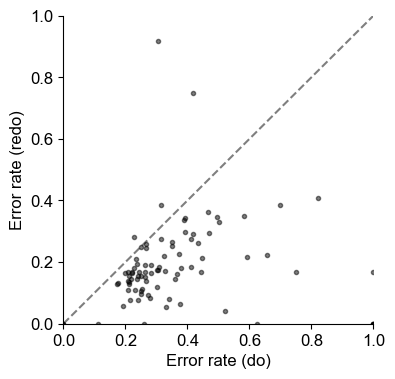

In [178]:
#scatter plot between error_rate_redo and error_rate_do
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
fig, ax=plt.subplots(1,1,figsize=(4,4))

valid_subnum = np.sum(~np.isnan(error_rate_redo),axis=0)
valid_subidx = np.where(~np.isnan(error_rate_redo))[0]

ax.scatter(error_rate_do, error_rate_redo, color='k', marker='.', alpha=0.5)

# get corrleation and p value
from scipy.stats import pearsonr, spearmanr
# corr, p = pearsonr(error_rate_do[valid_subidx], error_rate_redo[valid_subidx])
# print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))

corr, p = spearmanr(error_rate_do[valid_subidx], error_rate_redo[valid_subidx])
print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))

# xlabel, ylabel
ax.set_xlabel('Error rate (do)')
ax.set_ylabel('Error rate (redo)')

# xlim and ylim
ax.set_xlim([0,1])
ax.set_ylim([0,1])

# ticks
ax.set_xticks(np.arange(0,1.1,0.2))
ax.set_yticks(np.arange(0,1.1,0.2))

# diagonal line
ax.plot([0,1],[0,1], color='k', linestyle='--', alpha=0.5)

# save
fig.savefig(out_dir + 'error_rate_do_redo.png', transparent=True,
            bbox_inches='tight', pad_inches=0.1)

error rate(do) and error rate(redo): corr=0.239, p=0.024


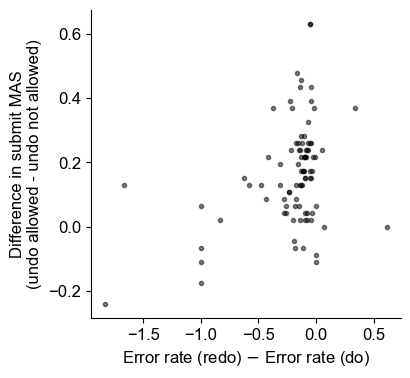

In [179]:
#scatter plot between error_rate_redo and error_rate_do
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
fig, ax=plt.subplots(1,1,figsize=(4,4))

valid_subnum = np.sum(~np.isnan(error_rate_redo),axis=0)
valid_subidx = np.where(~np.isnan(error_rate_redo))[0]

ax.scatter( error_rate_redo-error_rate_do, mas_gain_persub, color='k', marker='.', alpha=0.5)

# get corrleation and p value
from scipy.stats import pearsonr, spearmanr
# corr, p = pearsonr(error_rate_do[valid_subidx], error_rate_redo[valid_subidx])
# print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))
aa = error_rate_redo-error_rate_do
valid_idx = np.where(~np.isnan(aa))[0]
corr, p = spearmanr(error_rate_redo[valid_idx]-error_rate_do[valid_idx], mas_gain_persub[valid_idx])
print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))

# xlabel, ylabel
ax.set_xlabel(r'Error rate (redo) $-$ Error rate (do)')
ax.set_ylabel('Difference in submit MAS\n(undo allowed - undo not allowed)')

# set xlim
# ax.set_xlim([-.0,2])

# save
fig.savefig(out_dir + 'error_rate_do_redo_masgain.png', transparent=True,
            bbox_inches='tight', pad_inches=0.1)

In [180]:
mas_gain_persub.mean()

0.13804347826086957

error rate(do) and mas_gain: corr=-0.113, p=0.292
error rate(redo) and mas_gain: corr=0.330, p=0.002


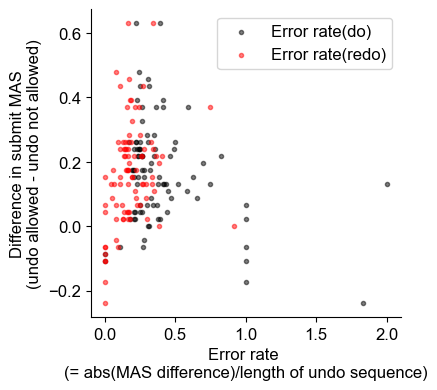

In [181]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
fig, ax=plt.subplots(1,1,figsize=(4,4))

valid_subnum = np.sum(~np.isnan(error_rate_redo),axis=0)
valid_subidx = np.where(~np.isnan(error_rate_redo))[0]
# overlap_seq_inorder_num_norm

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']


ax.scatter(error_rate_do, mas_gain_persub, color='k', marker='.', alpha=0.5, label='Error rate(do)')
ax.scatter(error_rate_redo, mas_gain_persub, color='r', marker='.', alpha=0.5, label='Error rate(redo)')

# get corrleation and p value
from scipy.stats import pearsonr, spearmanr
# corr, p = pearsonr(error_rate_do[valid_subidx], mas_gain_persub[valid_subidx])
# print('error rate(do) and mas_gain: corr={:.3f}, p={:.3f}'.format(corr, p))
# corr, p = pearsonr(error_rate_redo[valid_subidx], mas_gain_persub[valid_subidx])
# print('error rate(redo) and mas_gain: corr={:.3f}, p={:.3f}'.format(corr, p))

corr, p = spearmanr(error_rate_do[valid_subidx], mas_gain_persub[valid_subidx])
print('error rate(do) and mas_gain: corr={:.3f}, p={:.3f}'.format(corr, p))
corr, p = spearmanr(error_rate_redo[valid_subidx], mas_gain_persub[valid_subidx])
print('error rate(redo) and mas_gain: corr={:.3f}, p={:.3f}'.format(corr, p))

# xlabel, ylabel
ax.set_xlabel('Error rate \n(= abs(MAS difference)/length of undo sequence)')
ax.set_ylabel('Difference in submit MAS\n(undo allowed - undo not allowed)')

#legend
ax.legend(loc='upper right', frameon=True)

# save figure
fig.savefig(out_dir + 'error_rate_masgain.png', transparent=True,
            bbox_inches='tight', pad_inches=0.1)

## error rate (fixed metric)

In [182]:
data_error_rate = []

for sub in range(100):
    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    data_error_rate_puzzle = []
    print(sub)

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"] == 1].index
        path_bf_undo = dat_sbj_pzi["currMas"][firstUndo_idx - 1]  # the mas of the state before undo

        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"] == 1].index
        path_af_undo = dat_sbj_pzi["currMas"][lastUndo_idx + 1]  # the mas of the state after undo

        submit_idx = pd.Int64Index([len(dat_sbj_pzi) - 1])

        if len(firstUndo_idx) > 0:
            if len(firstUndo_idx) == 1:  #
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]


            else:
                seq_bf = dat_sbj_pzi["path"][firstUndo_idx - 1]
                t_idx = (firstUndo_idx[1:] - 1).to_list()
                t_idx.append(submit_idx.item())
                seq_af = dat_sbj_pzi["path"][t_idx]
                seq_im = dat_sbj_pzi["path"][lastUndo_idx]
                currmas_bf = dat_sbj_pzi["currMas"][lastUndo_idx - 1]
                currmas_af = dat_sbj_pzi["currMas"][lastUndo_idx + 1]

            firstundoidx = firstUndo_idx.to_numpy()-1
            lastundoidx = lastUndo_idx.to_numpy()
            tidx = np.array(t_idx) + 1
            tidx[-1] -= 1

            length_error_rate = []

            for i in range(len(firstundoidx)):
                currnct = dat_sbj_pzi["currNumCities"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct2 = currnct.copy()
                currmas = dat_sbj_pzi["currMas"][firstundoidx[i]:tidx[i]].to_numpy()
                currnct = currnct - min(currnct)
                currpath = dat_sbj_pzi["path"][firstundoidx[i]:tidx[i]].to_list()
                currpath = [currpath[i].strip('[').strip(']') for i in range(len(currpath))]
                currpath = [[int(i) for i in currpath[j].split(', ')] for j in range(len(currpath))]

                currRT = dat_sbj_pzi["RT"][firstundoidx[i]:tidx[i]].to_numpy()
                currundoRT = dat_sbj_pzi["undoRT"][firstundoidx[i]:tidx[i]].to_numpy()

                seq_im = dat_sbj_pzi["path"][lastundoidx[i]]
                pathStr_im = seq_im.strip('[').strip(']')
                pathList_im = [int(i) for i in pathStr_im.split(', ')]

                currpath = [np.setdiff1d(currpath[i], pathList_im).tolist() for i in range(len(currpath))]
                pathafter = [np.setdiff1d(pathList_af[i], pathList_im).tolist() for i in range(len(pathList_af))]

                idx_2 = np.where(currnct==0)[0]
                if len(idx_2)>1:
                    idx_2 = idx_2[0]

                if currnct[-1]==0:
                    # this means this perseon undo and submitted
                    continue
                else:
                    length_error_rate.append([np.abs(currmas[idx_2]-currmas[0]).squeeze()/currnct[0], np.abs(currmas[idx_2]-currmas[-1]).squeeze()/currnct[-1], sub, pzi]) # undo redo subid pzi

            data_error_rate_puzzle.extend(length_error_rate)

    data_error_rate.extend(data_error_rate_puzzle)
data_error_rate = np.array(data_error_rate)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1752650131.py:10: RuntimeWarning: Mean of empty slice
  error_rate_ = np.array([np.nanmean(data_error_rate[np.where(data_error_rate[:,2]==i)[0],:2], axis=0) for i in range(100)])


2.2273182113548116e-14 97.0


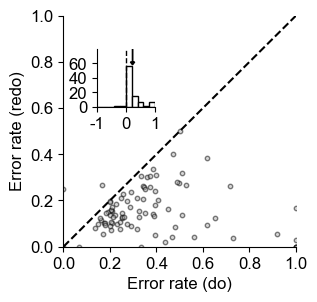

In [183]:
# scatter plot of time taken
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

# average over subjects, which is third column
error_rate_ = np.array([np.nanmean(data_error_rate[np.where(data_error_rate[:,2]==i)[0],:2], axis=0) for i in range(100)])

valid_subidx = np.where(~np.isnan(error_rate_[:,0]))[0]

plt.scatter(error_rate_[valid_subidx,0], error_rate_[valid_subidx,1], color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# # get plausible range of x and y and set xlim and ylim
# plt.xlim([0, 6])
# plt.ylim([0, 6])

plt.xlim([0, 1])
plt.ylim([0, 1])
#
# # set xticks and yticks
# plt.xticks([0,1,2,3,4,5,6])
# plt.yticks([0,1,2,3,4,5,6])

plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.yticks([0,0.2,0.4,0.6,0.8,1])

# set xand y label
plt.xlabel('Error rate (do)')
plt.ylabel('Error rate (redo)')
# title
# plt.title('Error magnitude')


# remove top and right frame
sns.despine()

# mid line
# plt.plot([0,6],[0,6], 'k--')
plt.plot([0,1],[0,1], 'k--')

# set xticks and yticks
# plt.xticks([0,5,10,15])
# plt.yticks([0,5,10,15])

# make inset and include hist_error_magnitude
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="25%", height="25%", loc=2, borderpad=2)
axins.hist(error_rate_[valid_subidx,0]-error_rate_[valid_subidx,1], bins=np.linspace(-1,1,11), color='w', alpha=1, label='Undo Allowed', edgecolor='k')
# center line of histogram at x = 0
axins.plot([0,0],[0,80], 'k--', linewidth=1)
axins.arrow(np.mean(error_rate_[valid_subidx,0]-error_rate_[valid_subidx,1]), 80, 0, -18, head_width=0.15, head_length=4, fc='k', ec='k')

# statistical test between currmas_with_undo and currmas_without_undo
from scipy.stats import wilcoxon
stat, p = wilcoxon(error_rate_[valid_subidx,0], error_rate_[valid_subidx,1])
print(p,stat)

# set x and y lim of axins
axins.set_xlim([-1, 1])
axins.set_ylim([0,80])

# set x and y ticks of axins
axins.set_xticks([-1,0,1])

# set xtickslabel of axins
axins.set_xticklabels(['-1','0','1'])
axins.set_yticks([0,20,40,60])


# remove top and right frame
sns.despine()

# save figure
plt.savefig(out_dir + '/error_rate_doredo.png', dpi=300, bbox_inches='tight')


In [184]:
print(error_rate_[valid_subidx,1]-error_rate_[valid_subidx,0])

[-0.42337662 -0.28354037 -0.0578373  -0.525      -0.11536281 -0.52083333
 -0.23333333 -0.125      -0.37144661 -0.05336284 -0.10668498 -0.13262108
 -0.1136566  -0.4570028  -0.10720551 -0.05441097 -0.24310658 -0.09088771
 -0.0468502  -0.11104269 -0.21212121 -1.         -0.86111111 -0.07159864
 -0.0495873  -0.04084492 -0.18939394 -0.23958333 -0.13244048 -0.04908009
 -0.25542328 -0.25892857 -0.34278274 -0.16661491 -0.10426829  0.25
 -0.02549603 -0.69345238 -0.03821369 -0.07708333 -0.04013367 -0.06964286
 -0.22400794 -0.20825893 -0.39434524 -0.04804422 -0.12064626 -0.06680403
 -1.          0.         -0.00396825 -0.41666667 -0.0440396  -0.33333333
  0.         -0.19592934 -0.06666667 -0.07540355 -0.97291667  0.1
 -0.08666667 -0.05503663 -0.07380952 -0.13367347 -0.0952381  -0.13936252
 -1.         -0.19990663  0.         -0.11358025 -0.16688312 -0.02682292
 -0.03675997 -0.08253968 -0.20850631 -0.20166667 -0.10256283 -0.12997199
 -0.08423181 -0.15392157 -0.17298535 -1.66666667 -0.52357143 -0.

error rate(do) and error rate(redo): corr=0.179, p=0.092
error rate(do) and error rate(redo): corr=0.295, p=0.005


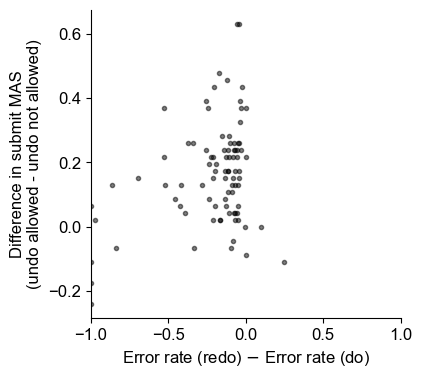

In [185]:
#scatter plot between error_rate_redo and error_rate_do
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
fig, ax=plt.subplots(1,1,figsize=(4,4))

valid_subidx = np.where(~np.isnan(error_rate_[:,0]))[0]

ax.scatter( error_rate_[valid_subidx,1]-error_rate_[valid_subidx,0], mas_gain_persub[valid_subidx], color='k', marker='.', alpha=0.5)

# get corrleation and p value
from scipy.stats import pearsonr, spearmanr
# corr, p = pearsonr(error_rate_do[valid_subidx], error_rate_redo[valid_subidx])
# print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))
aa = error_rate_[valid_subidx,1]-error_rate_[valid_subidx,0]
valid_idx = np.where(~np.isnan(aa))[0]
corr, p = spearmanr(aa, mas_gain_persub[valid_subidx])
print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))

corr, p = pearsonr(aa, mas_gain_persub[valid_subidx])
print('error rate(do) and error rate(redo): corr={:.3f}, p={:.3f}'.format(corr, p))

# xlabel, ylabel
ax.set_xlabel(r'Error rate (redo) $-$ Error rate (do)')
ax.set_ylabel('Difference in submit MAS\n(undo allowed - undo not allowed)')

# set xlim
ax.set_xlim([-1,1])

# save
fig.savefig(out_dir + 'error_rate_do_redo_masgain.png', transparent=True,
            bbox_inches='tight', pad_inches=0.1)

## overlap in order and regardless of order

In [186]:
print(overlap_inlen_p.shape)

(100, 8)


N=89
N=80
N=77
N=73
N=69
N=68
N=60
N=43


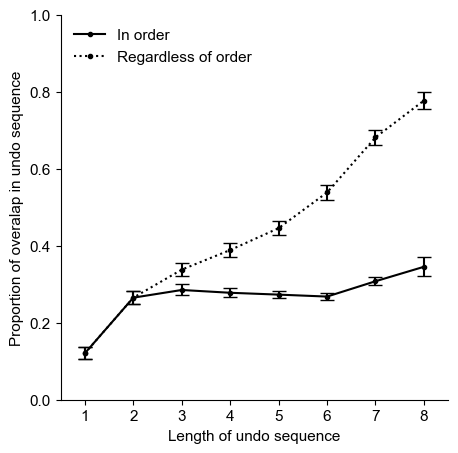

In [187]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(5,5))

valid_subnum = np.sum(~np.isnan(overlap_inlen_p),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(overlap_inlen_p,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_inlen_p,axis=0), yerr=np.nanstd(overlap_inlen_p,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(overlap_rglss_p,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_rglss_p,axis=0), yerr=np.nanstd(overlap_rglss_p,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


# for i in range(8):
#     ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')
for i in range(8):
    # print each
    print('N='+str(valid_subnum[i]))

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
ax.set_ylim([0,1])

# legend
ax.legend(['In order','Regardless of order'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Proportion of overalap in undo sequence')


# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'overlap_inorder_rglss_proportion.png', transparent=True)

N=89
N=80
N=77
N=73
N=69
N=68
N=60
N=43


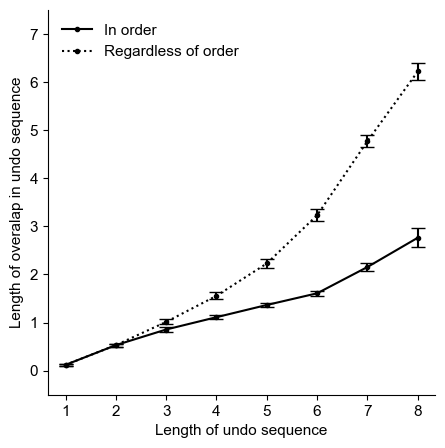

In [188]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(5,5))

valid_subnum = np.sum(~np.isnan(overlap_inlen),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(overlap_inlen,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_inlen,axis=0), yerr=np.nanstd(overlap_inlen,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(overlap_rglss,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(overlap_rglss,axis=0), yerr=np.nanstd(overlap_rglss,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


# for i in range(8):
#     ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')
for i in range(8):
    # print each
    print('N='+str(valid_subnum[i]))

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
# ax.set_ylim([0,1])

# legend
ax.legend(['In order','Regardless of order'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Length of overalap in undo sequence')


# set x label
ax.set_xlabel('Length of undo sequence')
ax.set_ylim([-0.5,7.5])

#save figure
fig.savefig(out_dir + 'overlap_inorder_rglss_numbers.png', transparent=True)

## MAS gain as a function of length

In [189]:
#import ttest 1samp
from scipy.stats import ttest_1samp, ttest_rel
ps = []
for ind in range(8):
    stat,p = ttest_rel(tortuosity[(~np.isnan(tortuosity[:,ind])),ind], [0]*np.sum((~np.isnan(tortuosity[:,ind])),))
    ps.append(p)
print(ps)

[nan, nan, 0.6106349965298539, 0.12507334628349948, 0.28139715943931, 0.04516897320073992, 0.6617007820952879, 0.32152809676380184]


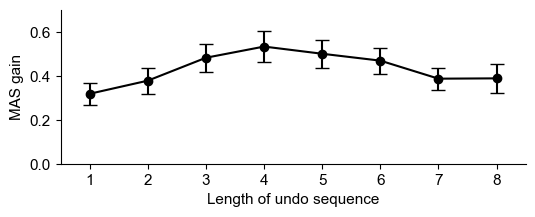

In [190]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(6,2))

valid_subnum = [np.sum(~np.isnan(mas[:,i])) for i in range(8)]

# ax.plot for currmas_num_inlen_p
ax.plot(np.arange(8), np.nanmean(mas,axis=0), color='k', marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas,axis=0), yerr=np.nanstd(mas,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)

# write valid_subnum as N=xx on the right top of each point
# for i in range(8):
#     ax.text(i + 0.4, np.nanmean(mas[:,i]) + np.nanstd(mas[:,i])/np.sqrt(valid_subnum[i])+0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

# bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
#         color=[.7,.7,.7], edgecolor = 'k',
#         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set y label
ax.set_ylabel('MAS gain')
# set x label
ax.set_xlabel('Length of undo sequence')
# set ylim
ax.set_yticks(np.arange(0,.7,.2))
ax.set_ylim([0,.7])

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()



# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
fig.savefig(out_dir + 'mas_gain_length_of_undone_path.png', dpi=600, bbox_inches='tight')

In [191]:
mas_1st_2nd_3rd.shape

(100, 8, 3)

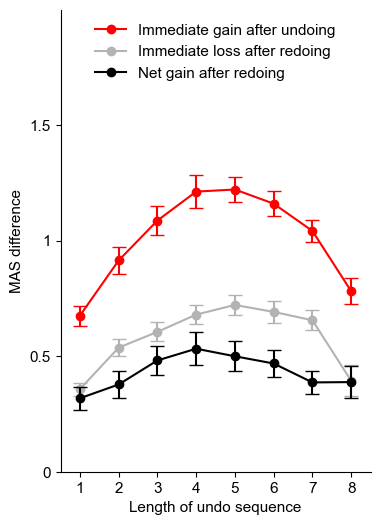

In [192]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

for ii in range(3):

    valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    # if ii == 0:
    #     # write valid_subnum as N=xx on the right top of each point
    #     for i in range(8):
    #         ax.text(i + 0.4, np.nanmean(mas_1st_2nd_3rd[:,i,ii]) + np.nanstd(mas_1st_2nd_3rd[:,i,ii])/np.sqrt(valid_subnum[i])+0.2, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

    # bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
    #         color=[.7,.7,.7], edgecolor = 'k',
    #         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('MAS difference')
    # set x label
    ax.set_xlabel('Length of undo sequence')


ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()
#2-1 3-2 3-1
# legend in a horizontally
ax.legend(['Immediate gain after undoing', 'Immediate loss after redoing', 'Net gain after redoing'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)
# Immediate gain after undoing
# Net gain after undoing
# Immediate loss after redoing

# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
fig.savefig(out_dir + 'mas_gain_length_of_undone_path_for_diff_undo.png', dpi=600, bbox_inches='tight')

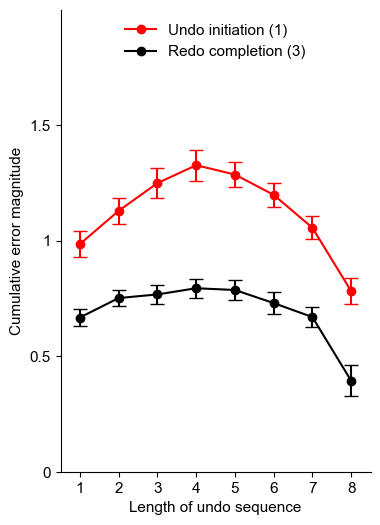

In [193]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

for ii in [0,2]:

    valid_subnum = [np.sum(~np.isnan(cumerror_1st_2nd_3rd[:,i,ii])) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(np.abs(cumerror_1st_2nd_3rd)[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(np.abs(cumerror_1st_2nd_3rd)[:,:,ii],axis=0), yerr=np.nanstd(cumerror_1st_2nd_3rd[:,:,ii],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('Cumulative error magnitude')
    # set x label
    ax.set_xlabel('Length of undo sequence')


ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

ax.legend(['Undo initiation (1)', 'Redo completion (3)'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)
# set xlim
ax.set_xlim([-0.5,7.5])


#save figure
fig.savefig(out_dir + 'cumerror_length_of_undone_path.png', dpi=600, bbox_inches='tight')

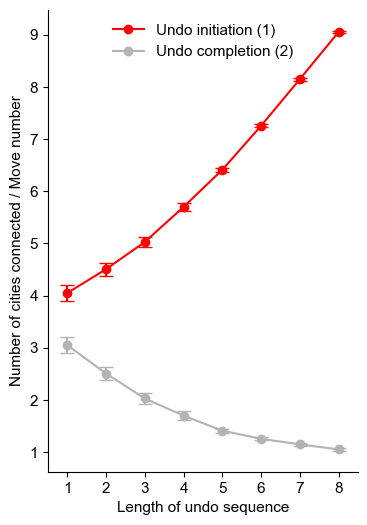

In [194]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

for ii in [0,1]:

    valid_subnum = [np.sum(~np.isnan(nct_123[:,i,ii])) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(np.abs(nct_123)[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(np.abs(nct_123)[:,:,ii],axis=0), yerr=np.nanstd(nct_123[:,:,ii],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('Number of cities connected / Move number')
    # set x label
    ax.set_xlabel('Length of undo sequence')


# ax.set_ylim([0, 2])
# ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

ax.legend(['Undo initiation (1)', 'Undo completion (2)'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)
# set xlim
ax.set_xlim([-0.5,7.5])

# save figure
fig.savefig(out_dir + 'nct_init_complete.png', dpi=600, bbox_inches='tight')

In [195]:
nct_123.shape

(100, 8, 3)

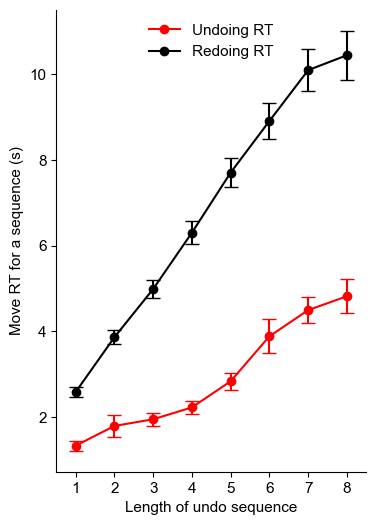

In [196]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]
colors = ['r', 'k',]

for ii in [0,1]:

    valid_subnum = [np.sum(~np.isnan(undo_redo_RT[:,i,ii]/1000)) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(np.abs(undo_redo_RT/1000)[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(np.abs(undo_redo_RT/1000)[:,:,ii],axis=0), yerr=np.nanstd(undo_redo_RT[:,:,ii]/1000,axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('Move RT for a sequence (s)')
    # set x label
    ax.set_xlabel('Length of undo sequence')


# ax.set_ylim([0, 2])
# ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

ax.legend(['Undoing RT', 'Redoing RT'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)
# set xlim
ax.set_xlim([-0.5,7.5])

# save figure
fig.savefig(out_dir + 'RT_of_undo_sequence.png', dpi=600, bbox_inches='tight')

In [197]:
newattempt_inlen = np.array([i - overlap_inlen[:, i-1] for i in range(1,9)])
newattempt_inlen = newattempt_inlen.transpose()

newattempt_rglss = np.array([i - overlap_rglss[:, i-1] for i in range(1,9)])
newattempt_rglss = newattempt_rglss.transpose()

In [198]:
print(newattempt_inlen)

[[0.90909091 1.5        1.83333333 2.75       3.8        4.66666667
         nan        nan]
 [0.95652174 1.66666667 2.25       3.         3.72222222 4.2
  5.16666667        nan]
 [0.83333333 1.42857143 2.02631579 2.62857143 3.43243243 3.93103448
  3.44444444 4.5       ]
 [1.         2.         2.         2.         3.66666667 4.66666667
         nan        nan]
 [0.9047619  1.47058824 2.05263158 2.375      3.23529412 3.88888889
  4.57142857 5.2       ]
 [       nan        nan        nan        nan        nan        nan
         nan        nan]
 [1.         1.33333333 2.         3.                nan        nan
         nan        nan]
 [1.         2.         3.         4.         4.         5.
         nan        nan]
 [0.25              nan        nan        nan        nan        nan
         nan        nan]
 [0.77272727 1.2        1.81481481 2.85294118 3.66666667 4.72413793
  5.5               nan]
 [0.83333333 1.24590164 2.01754386 2.82758621 3.57894737 4.12195122
  4.96774194 6.09

N=89
N=80
N=77
N=73
N=69
N=68
N=60
N=43


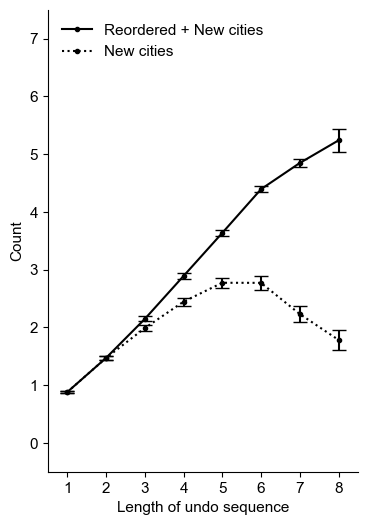

In [199]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11

fig, ax=plt.subplots(1,1,figsize=(4,6))


# remove top and right borders
sns.despine()
#2-1 3-2 3-1
valid_subnum = np.sum(~np.isnan(newattempt_inlen),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(newattempt_inlen,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(newattempt_inlen,axis=0), yerr=np.nanstd(newattempt_inlen,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


# for i in range(8):
#     ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')
for i in range(8):
    # print each
    print('N='+str(valid_subnum[i]))

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
# ax.set_ylim([0,1])

# legend
ax.legend(['Reordered + New cities','New cities'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Count')
ax.set_ylim([-0.5,7.5])



# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'newattempts_inorder_rglss_numbers.png', transparent=True)

N=89
N=80
N=77
N=73
N=69
N=68
N=60
N=43


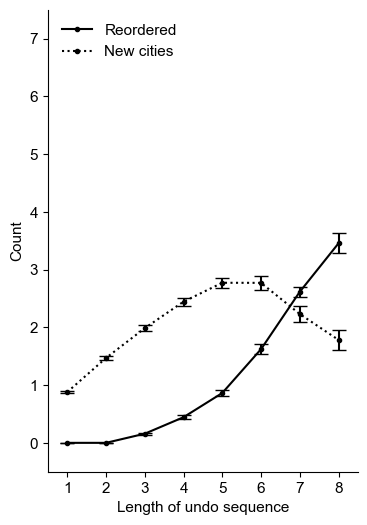

In [200]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11

fig, ax=plt.subplots(1,1,figsize=(4,6))


# remove top and right borders
sns.despine()
#2-1 3-2 3-1
valid_subnum = np.sum(~np.isnan(newattempt_inlen),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(newattempt_inlen-newattempt_rglss,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(newattempt_inlen-newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_inlen-newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


# for i in range(8):
#     ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')
for i in range(8):
    # print each
    print('N='+str(valid_subnum[i]))

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
# ax.set_ylim([0,1])

# legend
ax.legend(['Reordered','New cities'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Count')
ax.set_ylim([-0.5,7.5])



# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'newattempts_reorder_new_numbers.png', transparent=True)

In [201]:
(np.arange(1,9)- newattempt_rglss).shape

(100, 8)

N=89
N=80
N=77
N=73
N=69
N=68
N=60
N=43


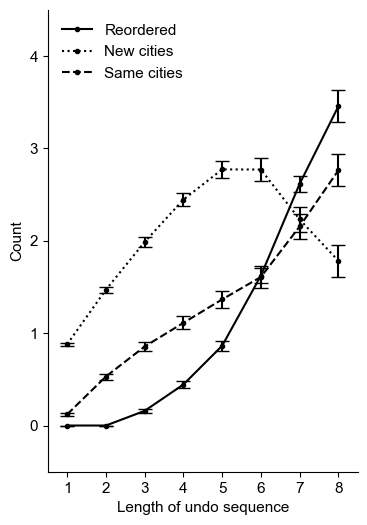

In [202]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11

fig, ax=plt.subplots(1,1,figsize=(4,6))


# remove top and right borders
sns.despine()
#2-1 3-2 3-1
valid_subnum = np.sum(~np.isnan(newattempt_inlen),axis=0)
# overlap_seq_inorder_num_norm

ax.plot(np.arange(0,8), np.nanmean(newattempt_inlen-newattempt_rglss,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(newattempt_inlen-newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_inlen-newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.plot(np.arange(0,8), np.arange(1,9)-np.nanmean(newattempt_inlen,axis=0), color='k', linestyle='--',marker='.')
ax.errorbar(np.arange(0,8), np.arange(1,9)-np.nanmean(newattempt_inlen,axis=0), yerr=np.nanstd((np.arange(1,9) - newattempt_rglss),axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


# for i in range(8):
#     ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')
for i in range(8):
    # print each
    print('N='+str(valid_subnum[i]))

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
# ax.set_ylim([0,1])

# legend
ax.legend(['Reordered','New cities', 'Same cities'], loc='upper left', frameon=False)

# set y label
ax.set_ylabel('Count')
ax.set_ylim([-0.5,4.5])



# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'newattempts_reorder_new_numbers.png', transparent=True)

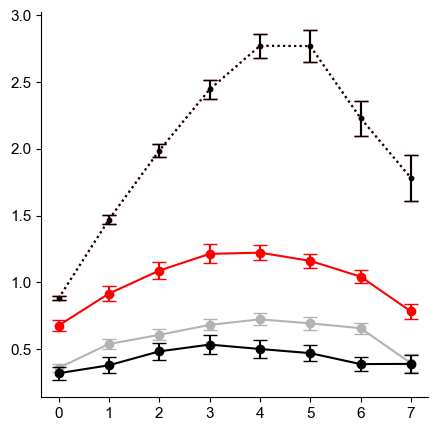

In [203]:
%matplotlib inline

# plot line between newattempt_rglss and each of mas_1st_2nd_3rd
fig, ax = plt.subplots(1,1,figsize=(5,5))

colors = ['r',  '0.7', 'k',]

valid_subnum = np.sum(~np.isnan(newattempt_rglss),axis=0)

for i in range(len(colors)):
    ax.plot(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), color=colors[i], linestyle=':',marker='.')
    ax.errorbar(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[i], capsize=5)

    ax.plot(np.arange(0,8), np.nanmean(mas_1st_2nd_3rd[:,:,i],axis=0), color=colors[i], marker='o')
    ax.errorbar(np.arange(0,8), np.nanmean(mas_1st_2nd_3rd[:,:,i],axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,i],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[i], capsize=5)


/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/982192324.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mas_1st_2nd_3rd[:,:,i]/newattempt_rglss
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/982192324.py:12: RuntimeWarning: invalid value encountered in true_divide
  ratio = mas_1st_2nd_3rd[:,:,i]/newattempt_rglss


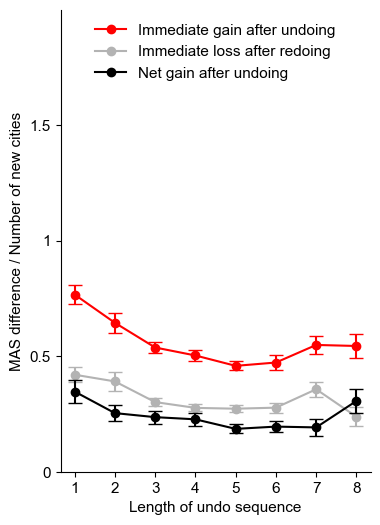

In [204]:
%matplotlib inline

# plot line between newattempt_rglss and each of mas_1st_2nd_3rd

fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

valid_subnum = np.sum(~np.isnan(newattempt_rglss),axis=0)

for i in range(len(colors)):
    ratio = mas_1st_2nd_3rd[:,:,i]/newattempt_rglss

    # remove that goes inf
    ratio[np.isinf(ratio)] = np.nan

    ax.plot(np.arange(1,9), np.nanmean(ratio,axis=0), color=colors[i], marker='o')
    ax.errorbar(np.arange(1,9), np.nanmean(ratio,axis=0), yerr=np.nanstd(ratio,axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[i], capsize=5)
ax.legend(['Immediate gain after undoing', 'Immediate loss after redoing', 'Net gain after undoing'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)

ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

ax.set_ylabel('MAS difference / Number of new cities')
# ax.set_ylim([-0.5,7.5])

# set x label
ax.set_xlabel('Length of undo sequence')

# set xlim
ax.set_xticks(np.arange(1,9))
ax.set_xticklabels(np.arange(1,9))


# save figure
fig.savefig(out_dir + 'mas_gain_per_newcities.png', dpi=600, bbox_inches='tight')

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2731780571.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mas_1st_2nd_3rd[:,:,i]/newattempt_inlen
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2731780571.py:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = mas_1st_2nd_3rd[:,:,i]/newattempt_inlen
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2731780571.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1,9))


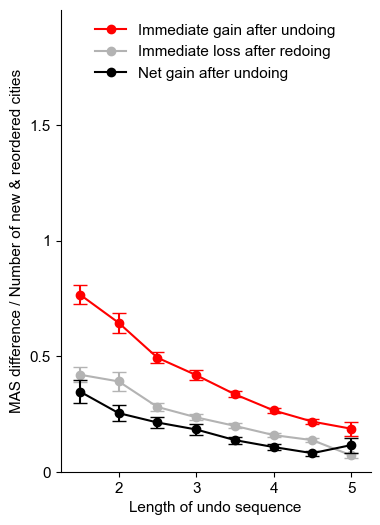

In [205]:
# figure for number of reordered and new cities
%matplotlib inline

# plot line between newattempt_inlen and each of mas_1st_2nd_3rd

fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

valid_subnum = np.sum(~np.isnan(newattempt_inlen),axis=0)

for i in range(len(colors)):
    ratio = mas_1st_2nd_3rd[:,:,i]/newattempt_inlen

    # remove that goes inf
    ratio[np.isinf(ratio)] = np.nan

    ax.plot(np.arange(1,9), np.nanmean(ratio,axis=0), color=colors[i], marker='o')
    ax.errorbar(np.arange(1,9), np.nanmean(ratio,axis=0), yerr=np.nanstd(ratio,axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[i], capsize=5)
ax.legend(['Immediate gain after undoing', 'Immediate loss after redoing', 'Net gain after undoing'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)

ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])
ax.set_xticklabels(np.arange(1,9))

ax.set_ylabel('MAS difference / Number of new & reordered cities')
# ax.set_ylim([-0.5,7.5])

# set x label
ax.set_xlabel('Length of undo sequence')

# set xlim
ax.set_xlim([0.5,8.5])

# save figure
fig.savefig(out_dir + 'mas_gain_per_newcitiesAndReordered.png', dpi=600, bbox_inches='tight')

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1125878145.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mas_1st_2nd_3rd[:,:,i]/(newattempt_inlen-newattempt_rglss)
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1125878145.py:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = mas_1st_2nd_3rd[:,:,i]/(newattempt_inlen-newattempt_rglss)
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1125878145.py:18: RuntimeWarning: Mean of empty slice
  ax.plot(np.arange(1,9), np.nanmean(ratio,axis=0), color=colors[i], marker='o')
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1125878145.py:19: RuntimeWarning: Mean of empty slice
  ax.errorbar(np.arange(1,9), np.nanmean(ratio,axis=0), yerr=np.nanstd(ratio,axis=0)/np.sqrt(valid_subnum),
/Users/dongjaekim/opt/anaconda3/envs/base310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slic

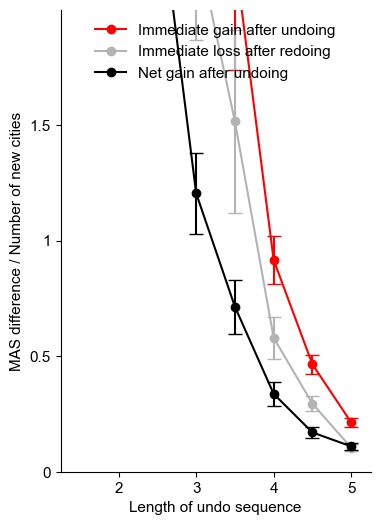

In [206]:
# figure for number of reordered and new cities
%matplotlib inline

# plot line between newattempt_inlen and each of mas_1st_2nd_3rd

fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

valid_subnum = np.sum(~np.isnan(newattempt_inlen-newattempt_rglss),axis=0)

for i in range(len(colors)):
    ratio = mas_1st_2nd_3rd[:,:,i]/(newattempt_inlen-newattempt_rglss)

    # remove that goes inf
    ratio[np.isinf(ratio)] = np.nan

    ax.plot(np.arange(1,9), np.nanmean(ratio,axis=0), color=colors[i], marker='o')
    ax.errorbar(np.arange(1,9), np.nanmean(ratio,axis=0), yerr=np.nanstd(ratio,axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[i], capsize=5)
ax.legend(['Immediate gain after undoing', 'Immediate loss after redoing', 'Net gain after undoing'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)

ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])
ax.set_xticklabels(np.arange(1,9))

ax.set_ylabel('MAS difference / Number of new cities')
# ax.set_ylim([-0.5,7.5])

# set x label
ax.set_xlabel('Length of undo sequence')

# set xlim
ax.set_xlim([0.5,8.5])

# save figure
fig.savefig(out_dir + 'mas_gain_per_Reordered.png', dpi=600, bbox_inches='tight')

In [207]:
# cumulative error as a function of move number
data_ = []
for sub in range(100):
    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    data_puzzle = []
    print(sub)

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        curr_nct = dat_sbj_pzi['currNumCities'].to_numpy()[:-1]
        curr_cumerror = (dat_sbj_pzi['currMas'][0]-dat_sbj_pzi['currMas']).to_numpy()[:-1]
        puzzle_mas = [dat_sbj_pzi['currMas'][0]]*len(curr_nct)

        data_puzzle.extend(np.array([puzzle_mas, curr_nct, curr_cumerror]).transpose())
    data_.append(data_puzzle)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# N more scatter plot and as a function of MAS

In [208]:
N_mores_per_mas = []
N_mores = []
N_mores_persub = []
# state MAS = N + N_more
# where they started undo

for sub in range(100):
    dat_sbj = sc_data_choice_level[sc_data_choice_level['subjects'] == sub].sort_values(["puzzleID", "index"])
    # N_mores_per_mas_puzzle = []
    N_mores_persub_puzzle = []
    print(sub)

    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()

        # find the index of the firstUndo
        firstUndo_idx = dat_sbj_pzi[dat_sbj_pzi["firstUndo"]==1].index-1
        # find the index of the lastUndo
        lastUndo_idx = dat_sbj_pzi[dat_sbj_pzi["lastUndo"]==1].index

        if len(firstUndo_idx) == 0:
            N_mores_per_mas.append([np.nan, np.nan, dat_sbj_pzi['currMas'][0]])
            N_mores.append([np.nan, np.nan, dat_sbj_pzi['currMas'][0]])
            N_mores_persub_puzzle.append([np.nan, np.nan, dat_sbj_pzi['currMas'][0]])
        else:
            N_more_ = dat_sbj_pzi['currMas']-dat_sbj_pzi['currNumCities']
            for i in range(len(firstUndo_idx)):
                N_mores_per_mas.append([N_more_[firstUndo_idx[i]], N_more_[lastUndo_idx[i]], dat_sbj_pzi['currMas'][0]])
                N_mores.append([N_more_[firstUndo_idx[i]], N_more_[lastUndo_idx[i]], dat_sbj_pzi['currMas'][0]])
                N_mores_persub_puzzle.append([N_more_[firstUndo_idx[i]], N_more_[lastUndo_idx[i]], dat_sbj_pzi['currMas'][0]])

    N_mores_persub.append(N_mores_persub_puzzle)# N_mores_per_mas_puzzle.append([N_more_[firstUndo_idx[i]], N_more_[

N_mores = np.array(N_mores)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [209]:
# calculate for each subject
N_more_bfundo = []
N_more_afundo = []
for sub in range(100):
    N_more_bfundo_sub = []
    N_more_afundo_sub = []
    for j in range(7,13):
        temp = np.array(N_mores_persub[sub])
        N_more_bfundo_sub.append(np.nanmean(temp[temp[:,2] == j,0]))
        N_more_afundo_sub.append(np.nanmean(temp[temp[:,2] == j,1]))
    N_more_bfundo.append(N_more_bfundo_sub)
    N_more_afundo.append(N_more_afundo_sub)
N_more_bfundo = np.array(N_more_bfundo)
N_more_afundo = np.array(N_more_afundo)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/84494525.py:9: RuntimeWarning: Mean of empty slice
  N_more_bfundo_sub.append(np.nanmean(temp[temp[:,2] == j,0]))
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/84494525.py:10: RuntimeWarning: Mean of empty slice
  N_more_afundo_sub.append(np.nanmean(temp[temp[:,2] == j,1]))


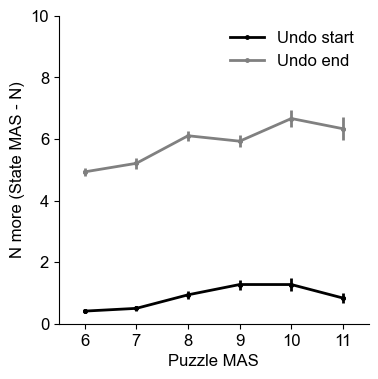

In [210]:
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(4,4))

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']

# line plot with error bar for average first-move RT
plt.plot(np.arange(6), np.nanmean(N_more_bfundo, axis=0), color=colors[0], linewidth=2, marker='.', markersize=5, label='Undo start')
plt.errorbar(np.arange(6), np.nanmean(N_more_bfundo, axis=0), yerr=np.nanstd(N_more_bfundo, axis=0)/np.sqrt(100), color=colors[0], linewidth=2, marker='.', markersize=5, label=None, linestyle='')
# line plot with error bar for average layer-move RT but in dashed line
plt.plot(np.arange(6), np.nanmean(N_more_afundo, axis=0), color=colors[1], linewidth=2, marker='.', markersize=5, label='Undo end')
plt.errorbar(np.arange(6), np.nanmean(N_more_afundo, axis=0), yerr=np.nanstd(N_more_afundo, axis=0)/np.sqrt(100), color=colors[1], linewidth=2, marker='.', markersize=5, label=None, linestyle='')

# set x and y lim
plt.xlim([-0.5, 5.5])
plt.ylim([0, 10])

sns.despine()

# set xticks
plt.xticks(np.arange(6), ['6', '7', '8', '9', '10', '11'])

# set x and y label
plt.xlabel('Puzzle MAS')
plt.ylabel('N more (State MAS - N)')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/N_more_bfaf.png', dpi=300, bbox_inches='tight')


In [211]:
# get N_mores that doesnt have np.nan
N_mores_nonan = N_mores[~np.isnan(N_mores[:,0]),:]

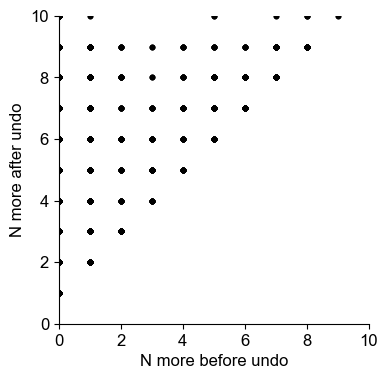

In [212]:
# scatter_hist of N_mores_nonan[:2]
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# set figure size
fig, ax = plt.subplots(figsize=(4,4))

# get two colors distinguishable for who cannot see red and green
colors= ['0', '0.5']

# scatter plot of N_mores_nonan[:,0] vs N_mores_nonan[:,1]
ax.scatter(N_mores_nonan[:,0], N_mores_nonan[:,1], color=colors[0], s=10, label=None)

# set x and y lim
plt.xlim([0, 10])
plt.ylim([0, 10])

# set x and y label
plt.xlabel('N more before undo')
plt.ylabel('N more after undo')

sns.despine()

# save figure
plt.savefig(out_dir + '/N_more_bfaf_scatter.png', dpi=600, bbox_inches='tight')

In [213]:

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

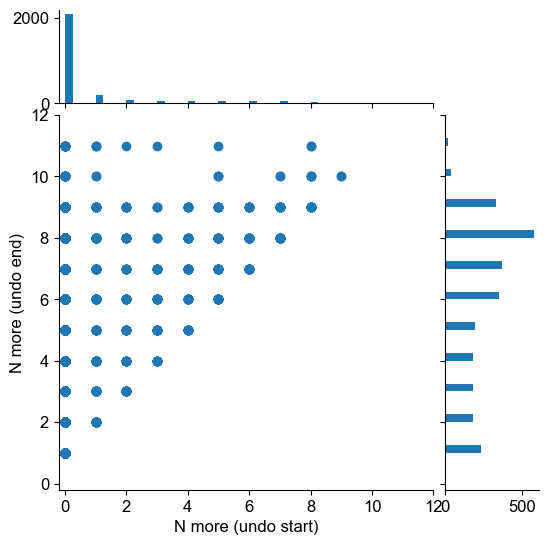

In [214]:
# scatter_hist of N_mores_nonan[:2]
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# set figure size


# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# change x and y lim from 0 to 12
ax.set_xlim([-0.2, 12])
ax.set_ylim([-0.2, 12])

# set xlabel N more (undo start) and set ylabel N more (undo end)
ax.set_xlabel('N more (undo start)')
ax.set_ylabel('N more (undo end)')


# Draw the scatter plot and marginals.
# scatter hist
scatter_hist(N_mores_nonan[:,0], N_mores_nonan[:,1], ax, ax_histx, ax_histy)


# save figure
plt.savefig(out_dir + '/N_more_bfaf_scatter_hist.png', dpi=600, bbox_inches='tight')

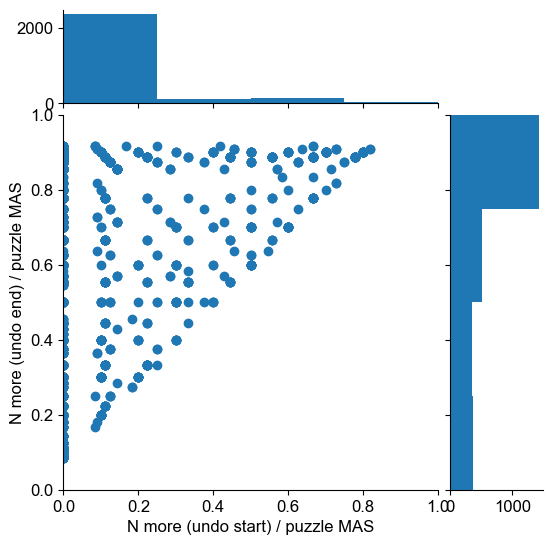

In [215]:
# scatter_hist of N_mores_nonan[:2]
%matplotlib inline

# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# set figure size


# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# change x and y lim from 0 to 12
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# set xlabel N more (undo start) and set ylabel N more (undo end)
ax.set_xlabel('N more (undo start) / puzzle MAS')
ax.set_ylabel('N more (undo end) / puzzle MAS')


# Draw the scatter plot and marginals.
# scatter hist
scatter_hist(N_mores_nonan[:,0]/N_mores_nonan[:,2], N_mores_nonan[:,1]/N_mores_nonan[:,2], ax, ax_histx, ax_histy)


# save figure
plt.savefig(out_dir + '/N_more_bfaf_puzzleMAS_scatter_hist.png', dpi=600, bbox_inches='tight')

# Redo efficiency

how good compared to the number of reordered cities, how good compared to the number of same cities

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3330363388.py:18: RuntimeWarning: Mean of empty slice
  ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), color=colors[ii], marker='.')
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/3330363388.py:19: RuntimeWarning: Mean of empty slice
  ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),


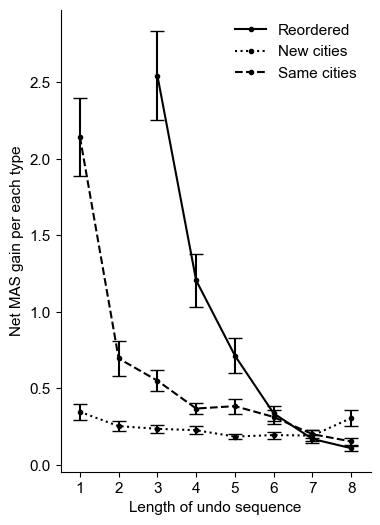

In [216]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

# proportion of new attempts
ii = 2
colors = ['r',  '0.7', 'k',]
valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]


reordered = (newattempt_inlen - newattempt_rglss)
# new_cities /= np.tile(np.arange(1,9), (100, 1))
# replace new_cities ==0 to nan
reordered[reordered==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), color=colors[ii], marker='.')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)


from copy import deepcopy
#proportion of new attempts
new_cities = deepcopy(newattempt_rglss)
# new_cities /= np.tile(np.arange(1,9), (100, 1))


# replace new_cities ==0 to nan
new_cities[new_cities==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0), color=colors[ii], linestyle=':',marker='.')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)



same_cities = (np.tile(np.arange(1,9), (100, 1)) - newattempt_inlen)

# new_cities /= np.tile(np.arange(1,9), (100, 1))


# replace new_cities ==0 to nan
same_cities[same_cities==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/same_cities,axis=0), color=colors[ii], linestyle='--',marker='.')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/same_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/same_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)




# set ylabel
ax.set_ylabel('Net MAS gain per each type')

# ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), color=colors[ii], marker='o', linestyle=':')
# ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color=colors[ii], capsize=5)

# set x and y lim
# plt.ylim([0, 10])

sns.despine()

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set xlim
ax.set_xlim([-0.5,7.5])

# set x and y label
plt.xlabel('Length of undo sequence')

# set legend
ax.legend(['Reordered','New cities', 'Same cities'], loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/mas_gain_per_each_cond.png', dpi=600, bbox_inches='tight')

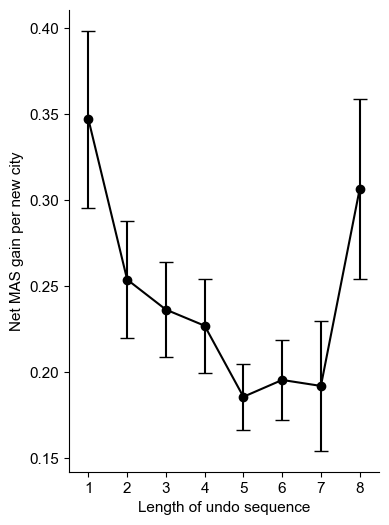

In [217]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

# proportion of new attempts
ii = 2
colors = ['r',  '0.7', 'k',]
valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

from copy import deepcopy
#proportion of new attempts
new_cities = deepcopy(newattempt_rglss)
# new_cities /= np.tile(np.arange(1,9), (100, 1))


# replace new_cities ==0 to nan
new_cities[new_cities==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0), color=colors[ii], marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

# set ylabel
ax.set_ylabel('Net MAS gain per new city')

# ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), color=colors[ii], marker='o', linestyle=':')
# ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color=colors[ii], capsize=5)

# set x and y lim
# plt.ylim([0, 10])

sns.despine()

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set xlim
ax.set_xlim([-0.5,7.5])

# set x and y label
plt.xlabel('Length of undo sequence')

# set legend

# save figure
plt.savefig(out_dir + '/mas_gain_per_newcities.png', dpi=600, bbox_inches='tight')

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1169644650.py:21: RuntimeWarning: Mean of empty slice
  ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), color=colors[ii], marker='o')
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1169644650.py:22: RuntimeWarning: Mean of empty slice
  ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


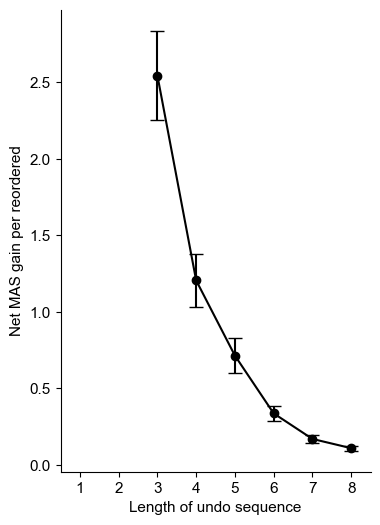

In [218]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

# proportion of new attempts
ii = 2
colors = ['r',  '0.7', 'k',]
valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

from copy import deepcopy
#proportion of new attempts
reordered = (newattempt_inlen - newattempt_rglss)
# new_cities /= np.tile(np.arange(1,9), (100, 1))


# replace new_cities ==0 to nan
reordered[reordered==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), color=colors[ii], marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

# set ylabel
ax.set_ylabel('Net MAS gain per reordered')

# ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), color=colors[ii], marker='o', linestyle=':')
# ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color=colors[ii], capsize=5)

# set x and y lim
# plt.ylim([0, 10])

sns.despine()

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set xlim
ax.set_xlim([-0.5,7.5])

# set x and y label
plt.xlabel('Length of undo sequence')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/mas_gain_per_reordered.png', dpi=600, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


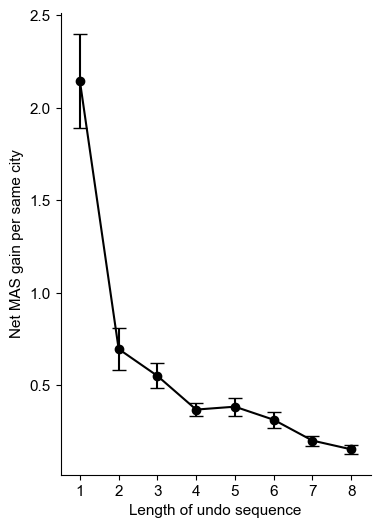

In [219]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

# proportion of new attempts
ii = 2
colors = ['r',  '0.7', 'k',]
valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

from copy import deepcopy
#proportion of new attempts
same_cities = (np.tile(np.arange(1,9), (100, 1)) - newattempt_inlen)

# new_cities /= np.tile(np.arange(1,9), (100, 1))


# replace new_cities ==0 to nan
same_cities[same_cities==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/same_cities,axis=0), color=colors[ii], marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/same_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/same_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

# set ylabel
ax.set_ylabel('Net MAS gain per same city')

# ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), color=colors[ii], marker='o', linestyle=':')
# ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color=colors[ii], capsize=5)

# set x and y lim
# plt.ylim([0, 10])

sns.despine()

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set xlim
ax.set_xlim([-0.5,7.5])

# set x and y label
plt.xlabel('Length of undo sequence')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/mas_gain_per_reordered.png', dpi=600, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


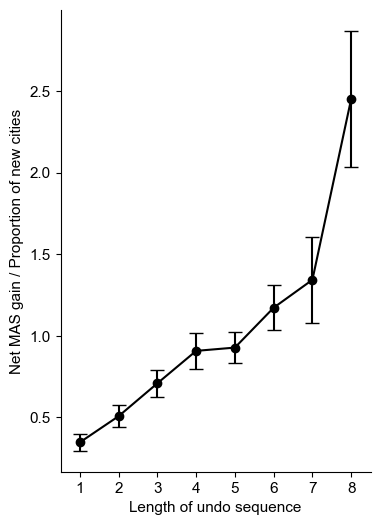

In [220]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

# proportion of new attempts
ii = 2
colors = ['r',  '0.7', 'k',]
valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

from copy import deepcopy
#proportion of new attempts
new_cities = deepcopy(newattempt_rglss)
new_cities /= np.tile(np.arange(1,9), (100, 1))


# replace new_cities ==0 to nan
new_cities[new_cities==0] = np.nan

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0), color=colors[ii], marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

# set ylabel
ax.set_ylabel('Net MAS gain / Proportion of new cities')

# ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), color=colors[ii], marker='o', linestyle=':')
# ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color=colors[ii], capsize=5)

# set x and y lim
# plt.ylim([0, 10])

sns.despine()

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set xlim
ax.set_xlim([-0.5,7.5])

# set x and y label
plt.xlabel('Length of undo sequence')

# set legend
plt.legend(loc='upper right', frameon=False)

# save figure
plt.savefig(out_dir + '/mas_gain_per_prop_newcities.png', dpi=600, bbox_inches='tight')

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2418384634.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(reordered,axis=0), color=colors[ii], marker='o')
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2418384634.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2418384634.py:15: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),
/Users/dongjaekim/opt/anaconda3/envs/base310/lib/python3.10/site-packages/numpy/core/from

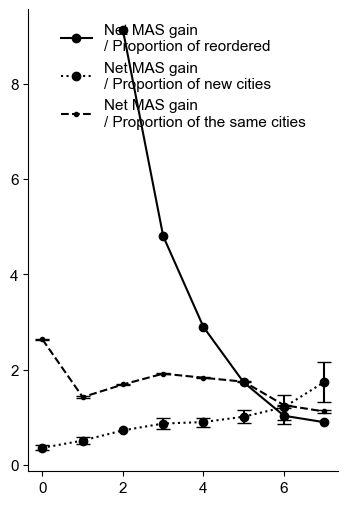

In [221]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

ii = 2

colors = ['r',  '0.7', 'k',]
valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

reordered = (newattempt_inlen - newattempt_rglss)/np.tile(np.arange(1,9), (100, 1))
# net gain / non-new cities (reordered cities or cites in the same order
ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(reordered,axis=0), color=colors[ii], marker='o')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(reordered,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/reordered,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

from copy import deepcopy
#proportion of new attempts
new_cities = deepcopy(newattempt_rglss)
new_cities /= np.tile(np.arange(1,9), (100, 1))

ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), color=colors[ii], marker='o', linestyle=':')
ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(new_cities,axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii]/new_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

# proportion of same cities
same_cities = (np.tile(np.arange(1,9), (100, 1)) - newattempt_inlen)/np.tile(np.arange(1,9), (100, 1))
ax.plot(np.arange(0,8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(same_cities,axis=0), color='k', linestyle='--',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.nanmean(same_cities,axis=0), yerr=np.nanstd(same_cities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


ax.legend(['Net MAS gain \n/ Proportion of reordered', 'Net MAS gain \n/ Proportion of new cities', 'Net MAS gain \n/ Proportion of the same cities'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)

# # ax.legend(['Reordered','New cities', 'Same cities'], loc='upper left', frameon=False)
# ax.plot(np.arange(0,8), np.nanmean(newattempt_inlen-newattempt_rglss,axis=0), color='k', marker='.')
# ax.errorbar(np.arange(0,8), np.nanmean(newattempt_inlen-newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_inlen-newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color='k', capsize=5)
#
#
# ax.plot(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), color='k', linestyle=':',marker='.')
# ax.errorbar(np.arange(0,8), np.nanmean(newattempt_rglss,axis=0), yerr=np.nanstd(newattempt_rglss,axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color='k', capsize=5)
#
#
# ax.plot(np.arange(0,8), np.arange(1,9)-np.nanmean(newattempt_inlen,axis=0), color='k', linestyle='--',marker='.')
# ax.errorbar(np.arange(0,8), np.arange(1,9)-np.nanmean(newattempt_inlen,axis=0), yerr=np.nanstd((np.arange(1,9) - newattempt_rglss),axis=0)/np.sqrt(valid_subnum),
#             linestyle='', color='k', capsize=5)

### scatter plot for net gain and proportion of new cities


In [222]:
same_cities

array([[0.09090909, 0.25      , 0.38888889, 0.3125    , 0.24      ,
        0.22222222,        nan,        nan],
       [0.04347826, 0.16666667, 0.25      , 0.25      , 0.25555556,
        0.3       , 0.26190476,        nan],
       [0.16666667, 0.28571429, 0.3245614 , 0.34285714, 0.31351351,
        0.34482759, 0.50793651, 0.4375    ],
       [0.        , 0.        , 0.33333333, 0.5       , 0.26666667,
        0.22222222,        nan,        nan],
       [0.0952381 , 0.26470588, 0.31578947, 0.40625   , 0.35294118,
        0.35185185, 0.34693878, 0.35      ],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [0.        , 0.33333333, 0.33333333, 0.25      ,        nan,
               nan,        nan,        nan],
       [0.        , 0.        , 0.        , 0.        , 0.2       ,
        0.16666667,        nan,        nan],
       [0.75      ,        nan,        nan,        nan,        nan,
               nan,        n

In [223]:
np.sum(new_cities<0)

0

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2006474291.py:29: RuntimeWarning: Mean of empty slice
  plt.scatter(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')


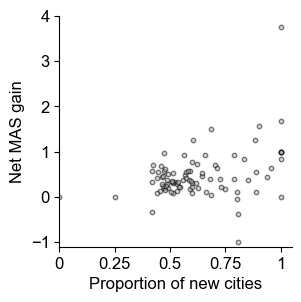

In [224]:
# scatter plot for net gain and proportion of new cities
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

ii = 2

# set x and y lim
plt.xlim([0, 1.05])
plt.xticks([0,0.25,0.5,0.75,1], ['0','0.25','0.5','0.75','1'])

plt.ylim(([-1.1, 4]))
# plt.ylim([0, 1])

# set xlabel N more (undo start) and set ylabel N more (undo end)
plt.xlabel('Proportion of new cities')
plt.ylabel('Net MAS gain')

from copy import deepcopy
#proportion of new attempts
new_cities = deepcopy(newattempt_rglss)
new_cities /= np.tile(np.arange(1,9), (100, 1))
# scatter plot
# plt.plot(np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), np.nanmean(new_cities,axis=1), marker='o', linestyle='')
# plt.plot(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), marker='o', linestyle='')
plt.scatter(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# remove top and right borders
sns.despine()

# save figure
plt.savefig(out_dir + '/NET_mas_gain_prop_newcities_scatter.png', dpi=600)

In [225]:
print(np.nanmean(new_cities,axis=1))

[0.703367   0.55832964 0.49231151 0.68333333 0.4585619         nan
 0.5625     0.88333333 0.25       0.59719993 0.53174523 0.58346578
 0.51156469 0.59272751 0.46554389 0.47107909 0.46726271 0.42152529
 0.56621348 0.46926632 0.49130215 0.74747475 1.         1.
 0.41728573 0.52295323        nan 0.54421263 0.51112689 0.47321429
 0.61490157 0.45264138 0.62059796 0.5984127  0.6798566  0.44206529
 0.64519375 1.         0.80157634 0.60416667 0.58931335 0.85297675
        nan 0.50552714 0.7102466  0.66221208 0.53320627        nan
 0.88888889 0.44353741 0.57373583 0.5140625  1.         0.68496803
 0.8042517  0.9375            nan 0.46476248 0.88888889 0.
 0.48387715 0.41666667 0.62690901 0.83333333        nan 0.80555556
 0.95555556 0.43909928 0.53877972        nan 0.90285714        nan
 0.72619048 0.50920166 1.         0.56993567 0.41666667 0.47350514
 0.58965097 0.59757772        nan 0.48787865 0.7875     0.50768201
 0.79009354 0.58000691        nan 0.64514456 0.47759395 0.60047397
 0.47689778

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1315550892.py:1: RuntimeWarning: Mean of empty slice
  print(np.nanmean(new_cities,axis=1))


In [226]:
# spearman correlation
from scipy.stats import spearmanr

new_ = np.nanmean(new_cities,axis=1)
mas_ = np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1)
# not nan
new_ = new_[~np.isnan(new_)]
mas_ = mas_[~np.isnan(mas_)]
spearmanr(new_, mas_)
# spearmanr(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1))

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1648814200.py:4: RuntimeWarning: Mean of empty slice
  new_ = np.nanmean(new_cities,axis=1)
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/1648814200.py:5: RuntimeWarning: Mean of empty slice
  mas_ = np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1)


SignificanceResult(statistic=0.29099162954331675, pvalue=0.005665468331814402)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/4170578710.py:28: RuntimeWarning: Mean of empty slice
  plt.scatter(np.nanmean(reordered,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')


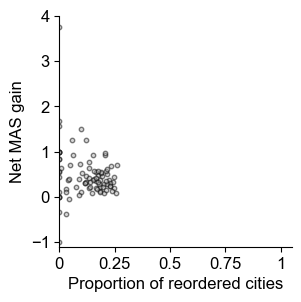

In [227]:
# scatter plot for net gain and proportion of new cities
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

ii = 2

# set x and y lim
plt.xlim([0, 1.05])
plt.xticks([0,0.25,0.5,0.75,1], ['0','0.25','0.5','0.75','1'])

plt.ylim(([-1.1, 4]))
# plt.ylim([0, 1])

# set xlabel N more (undo start) and set ylabel N more (undo end)
plt.xlabel('Proportion of reordered cities')
plt.ylabel('Net MAS gain')

from copy import deepcopy
#proportion of new attempts
# scatter plot
# plt.plot(np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), np.nanmean(new_cities,axis=1), marker='o', linestyle='')
# plt.plot(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), marker='o', linestyle='')
# same_cities reordered
plt.scatter(np.nanmean(reordered,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# remove top and right borders
sns.despine()

# save figure
plt.savefig(out_dir + '/NET_mas_gain_prop_reordered_scatter.png', dpi=600)

In [228]:
# spearman correlation
from scipy.stats import spearmanr

reordered_ = np.nanmean(reordered,axis=1)
mas_ = np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1)
# not nan
reordered_ = reordered_[~np.isnan(reordered_)]
mas_ = mas_[~np.isnan(mas_)]
spearmanr(reordered_, mas_)
# spearmanr(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1))

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/145445698.py:4: RuntimeWarning: Mean of empty slice
  reordered_ = np.nanmean(reordered,axis=1)
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/145445698.py:5: RuntimeWarning: Mean of empty slice
  mas_ = np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1)


SignificanceResult(statistic=-0.13078373149922223, pvalue=0.2218497300919043)

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/2324896100.py:28: RuntimeWarning: Mean of empty slice
  plt.scatter(np.nanmean(same_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')


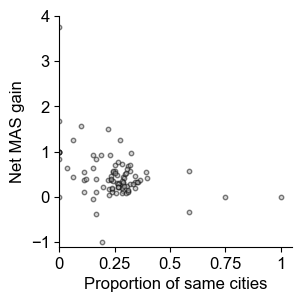

In [229]:
# scatter plot for net gain and proportion of new cities
%matplotlib inline
# set font and font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(3,3))

ii = 2

# set x and y lim
plt.xlim([0, 1.05])
plt.xticks([0,0.25,0.5,0.75,1], ['0','0.25','0.5','0.75','1'])

plt.ylim(([-1.1, 4]))
# plt.ylim([0, 1])

# set xlabel N more (undo start) and set ylabel N more (undo end)
plt.xlabel('Proportion of same cities')
plt.ylabel('Net MAS gain')

from copy import deepcopy
#proportion of new attempts
# scatter plot
# plt.plot(np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), np.nanmean(new_cities,axis=1), marker='o', linestyle='')
# plt.plot(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), marker='o', linestyle='')
# same_cities reordered
plt.scatter(np.nanmean(same_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1), color=[.7,.7,.7], s=10, alpha=0.5, edgecolor = 'k')

# remove top and right borders
sns.despine()

# save figure
plt.savefig(out_dir + '/NET_mas_gain_prop_same_scatter.png', dpi=600)

In [230]:
# spearman correlation
from scipy.stats import spearmanr

same_cities_ = np.nanmean(same_cities,axis=1)
mas_ = np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1)
# not nan
same_cities_ = same_cities_[~np.isnan(same_cities_)]
mas_ = mas_[~np.isnan(mas_)]
spearmanr(same_cities_, mas_)
# spearmanr(np.nanmean(new_cities,axis=1), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1))

/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/4144437596.py:4: RuntimeWarning: Mean of empty slice
  same_cities_ = np.nanmean(same_cities,axis=1)
/var/folders/8q/yjgzft41043gt_l8bqcfnzn40000gn/T/ipykernel_32955/4144437596.py:5: RuntimeWarning: Mean of empty slice
  mas_ = np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=1)


SignificanceResult(statistic=-0.29552926459544604, pvalue=0.004928079749464303)

# RT and redo

How efficient that redo is
redo RT based on the overlapped length or reordered ones

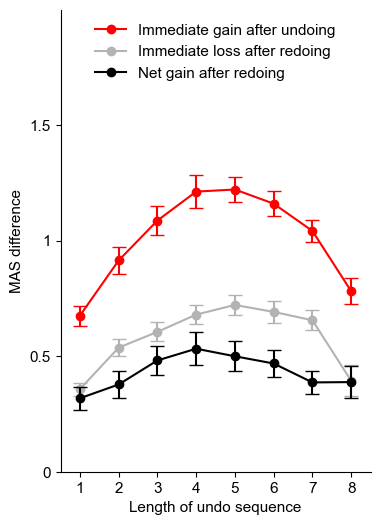

In [231]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]

for ii in range(3):

    valid_subnum = [np.sum(~np.isnan(mas_1st_2nd_3rd[:,i,ii])) for i in range(8)]

    # ax.plot for currmas_num_inlen_p
    ax.plot(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), color=colors[ii], marker='o')
    ax.errorbar(np.arange(8), np.nanmean(mas_1st_2nd_3rd[:,:,ii],axis=0), yerr=np.nanstd(mas_1st_2nd_3rd[:,:,ii],axis=0)/np.sqrt(valid_subnum),
                linestyle='', color=colors[ii], capsize=5)

    # if ii == 0:
    #     # write valid_subnum as N=xx on the right top of each point
    #     for i in range(8):
    #         ax.text(i + 0.4, np.nanmean(mas_1st_2nd_3rd[:,i,ii]) + np.nanstd(mas_1st_2nd_3rd[:,i,ii])/np.sqrt(valid_subnum[i])+0.2, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')

    # bb = plt.bar(range(7), np.nanmean(currmas_inlen_p,axis=0),
    #         color=[.7,.7,.7], edgecolor = 'k',
    #         yerr=np.nanstd(currmas_inlen_p,axis = 0)/np.sqrt(currmas_inlen_p.shape[0]))

    ax.set_xticks(np.arange(0,8))
    ax.set_xlim([-0.5,8.5])
    # set xtickslabel
    ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

    # set y label
    ax.set_ylabel('MAS difference')
    # set x label
    ax.set_xlabel('Length of undo sequence')


ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

# set xlim
ax.set_xlim([-0.5,7.5])




# remove top and right borders
sns.despine()
#2-1 3-2 3-1
# legend in a horizontally
ax.legend(['Immediate gain after undoing', 'Immediate loss after redoing', 'Net gain after redoing'], loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True)
# Immediate gain after undoing
# Net gain after undoing
# Immediate loss after redoing

# #statistics
# x1, x2 = 2,3
# y, h, col = np.max([bb[2].get_height(),bb[3].get_height()]) + 0.1, 0.05, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, r"$p = {:f}$".format(p12), ha='center', va='bottom', color=col, fontsize = 8)

# save figure
# fig.savefig(out_dir + 'mas_gain_length_of_undone_path_for_diff_undo.png', dpi=600, bbox_inches='tight')

N=89
N=80
N=77
N=73
N=69
N=68
N=60
N=43


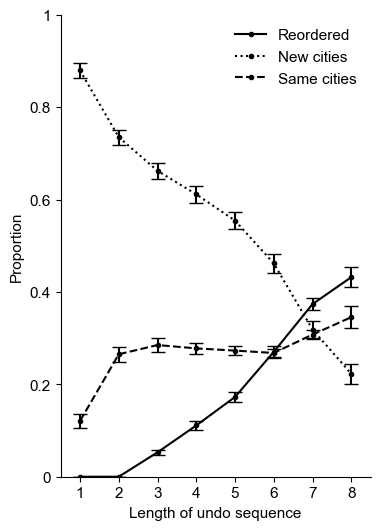

In [232]:
%matplotlib inline
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11

fig, ax=plt.subplots(1,1,figsize=(4,6))


# remove top and right borders
sns.despine()
#2-1 3-2 3-1
valid_subnum = np.sum(~np.isnan(newattempt_inlen),axis=0)
# overlap_seq_inorder_num_norm


# proportion of reordered
prop_reordered=(newattempt_inlen - newattempt_rglss)/np.tile(np.arange(1,9), (100, 1))
ax.plot(np.arange(0,8), np.nanmean(prop_reordered,axis=0), color='k', marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(prop_reordered, axis=0), yerr=np.nanstd(prop_reordered,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)

# proportion of new cities
prop_newcities = newattempt_rglss/np.tile(np.arange(1,9), (100, 1))
ax.plot(np.arange(0,8), np.nanmean(prop_newcities,axis=0), color='k', linestyle=':',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(prop_newcities,axis=0), yerr=np.nanstd(prop_newcities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)

# proportion of same cities
prop_samecities = (np.tile(np.arange(1,9), (100, 1)) - newattempt_inlen)/np.tile(np.arange(1,9), (100, 1))
ax.plot(np.arange(0,8), np.nanmean(prop_samecities,axis=0), color='k', linestyle='--',marker='.')
ax.errorbar(np.arange(0,8), np.nanmean(prop_samecities,axis=0), yerr=np.nanstd(prop_samecities,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color='k', capsize=5)


# for i in range(8):
#     ax.text(i + 0.5, np.nanmean(overlap_inlen_p[:,i]) -0.05, 'N='+str(valid_subnum[i]), ha='center', va='center', color='k')
for i in range(8):
    # print each
    print('N='+str(valid_subnum[i]))

# remove top and right borders
sns.despine()
# set x ticks
ax.set_xticks(np.arange(0,8))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlim([-0.5,7.5])
# ax.set_ylim([0,1])

# legend
ax.legend(['Reordered','New cities', 'Same cities'], loc='upper right', frameon=False)

# set y label
ax.set_ylabel('Proportion')
ax.set_ylim([0,1])
# set yticks 0, 0.2, 0.4, 0.6, 0.8, 1
ax.set_yticks(np.arange(0,1.2,0.2),['0','0.2','0.4','0.6','0.8','1'])



# set x label
ax.set_xlabel('Length of undo sequence')

#save figure
fig.savefig(out_dir + 'newattempts_reorder_new_proportions.png', transparent=True)

(-0.5, 7.5)

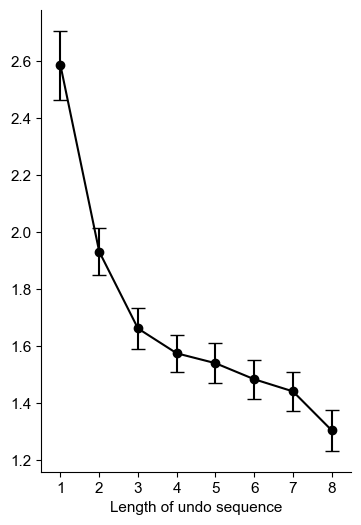

In [233]:
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 11
fig, ax=plt.subplots(1,1,figsize=(4,6))

colors = ['r',  '0.7', 'k',]
colors = ['r', 'k',]
ii = 1
# for ii in [0,1]:

valid_subnum = [np.sum(~np.isnan(undo_redo_RT[:,i,ii]/1000)) for i in range(8)]

# prop_notnew = (np.tile(np.arange(1,9), (100, 1)) - newattempt_rglss)/np.tile(np.arange(1,9), (100, 1))
# prop_notnew = (np.tile(np.arange(1,9), (100, 1)) - newattempt_rglss)
# prop_notnew[prop_notnew == 0] = np.nan

prop_notnew = (np.tile(np.arange(1,9), (100, 1)))
# ax.plot for currmas_num_inlen_p
ax.plot(np.arange(8), np.nanmean(np.abs(undo_redo_RT/1000)[:,:,ii]/prop_notnew,axis=0), color=colors[ii], marker='o')
ax.errorbar(np.arange(8), np.nanmean(np.abs(undo_redo_RT/1000)[:,:,ii]/prop_notnew,axis=0), yerr=np.nanstd(undo_redo_RT[:,:,ii]/1000/prop_notnew,axis=0)/np.sqrt(valid_subnum),
            linestyle='', color=colors[ii], capsize=5)

ax.set_xticks(np.arange(0,8))
ax.set_xlim([-0.5,8.5])
# set xtickslabel
ax.set_xticklabels(['1','2','3','4', '5', '6', '7', '8'])

# set y label
# ax.set_ylabel('RT of undo sequence (s)')
# set x label
ax.set_xlabel('Length of undo sequence')


# ax.set_ylim([0, 2])
# ax.set_yticks(np.arange(0,2,0.5),['0','0.5','1','1.5'])

# ax.legend(['Undoing RT', 'Redoing RT'], loc='upper center', bbox_to_anchor=(0.5, 1),
#           ncol=1, fancybox=True)
# set xlim
ax.set_xlim([-0.5,7.5])

# save figure
# fig.savefig(out_dir + 'RT_of_undo_sequence.png', dpi=600, bbox_inches='tight')